In [1]:
import matplotlib.pyplot as plt
from lsst.rsp import get_tap_service
import numpy as np
import os
import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord

from lsst.daf.butler import Butler
from lsst.daf.butler.registry import ConflictingDefinitionError
import lsst.afw.display as afwDisplay
import lsst.geom as geom
from lsst.source.injection import ingest_injection_catalog, generate_injection_catalog
from lsst.source.injection import VisitInjectConfig, VisitInjectTask
import lsst.sphgeom
from lsst.pipe.tasks.registerImage import RegisterConfig, RegisterTask

afwDisplay.setDefaultBackend('matplotlib')
plt.style.use('tableau-colorblind10')


butler_config = 'dp02'
collections = '2.2i/runs/DP0.2'
butler = Butler(butler_config, collections=collections)

In [20]:
dataId = {'visit': 192350, 'detector': 175, 'band': 'i'}
calexp = butler.get('calexp', **dataId)
pc = calexp.photoCalib

In [32]:
help(pc)
zf = pc.getInstFluxAtZeroMagnitude()
pc.instFluxToMagnitude(zf), -2.5 * np.log10(zf)

Help on PhotoCalib in module lsst.afw.image object:

class PhotoCalib(lsst.afw.typehandling.Storable)
 |  Method resolution order:
 |      PhotoCalib
 |      lsst.afw.typehandling.Storable
 |      lsst.afw.table.io.Persistable
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __eq__(...)
 |      __eq__(self: lsst.afw.image.PhotoCalib, arg0: lsst.afw.image.PhotoCalib) -> bool
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: lsst.afw.image.PhotoCalib) -> None
 |      
 |      2. __init__(self: lsst.afw.image.PhotoCalib, calibrationMean: float, calibrationErr: float = 0.0, bbox: lsst.geom.Box2I = Box2I(corner=Point2I(0, 0), dimensions=Extent2I(0, 0))) -> None
 |      
 |      3. __init__(self: lsst.afw.image.PhotoCalib, calibration: lsst::afw::math::BoundedField, calibrationErr: float = 0.0) -> None
 |      
 |      4. __init__(self: lsst.afw.image.PhotoCalib, ca

(-2.4108186663832173e-16, -31.85101740864034)

In [13]:
import lsst.afw.image as afwImage
from lsst.meas.algorithms import SourceDetectionTask, SourceDetectionConfig
from lsst.meas.base import SingleFrameMeasurementTask, SingleFrameMeasurementConfig
schema = afwTable.SourceTable.makeMinimalSchema()
tab = afwTable.SourceTable.make(schema)

# Step 2: Detect sources
detectionConfig = SourceDetectionConfig()
detectionTask = SourceDetectionTask(config=detectionConfig)
detectResult = detectionTask.run(exposure=exposure)
sources = detectResult.sources

# Step 3: Measure fluxes
measureConfig = SingleFrameMeasurementConfig()
measureTask = SingleFrameMeasurementTask(config=measureConfig)
measureTask.run(exposure, sources)

# Step 4: Calibrate the fluxes and extract magnitudes
photoCalib = exposure.getPhotoCalib()

for source in sources:
    flux = source.get("base_PsfFlux_instFlux")
    fluxErr = source.get("base_PsfFlux_instFluxErr")
    mag, magErr = photoCalib.instFluxToMagnitude(flux, fluxErr)
    print(f"Source ID: {source.getId()}, Magnitude: {mag}, Magnitude Error: {magErr}")



NameError: name 'afwTable' is not defined

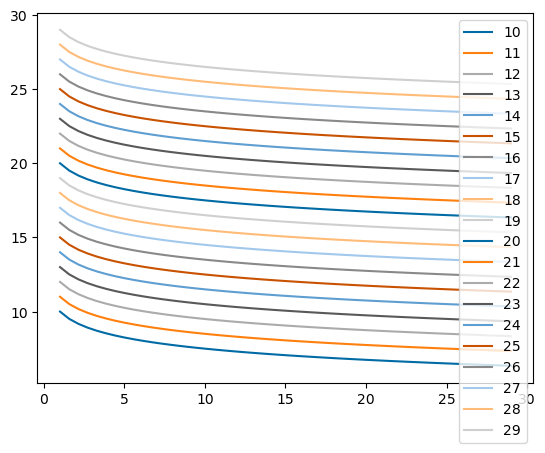

In [17]:
def flux_to_mag(Flux, Flux_err = "", F0=27.85):
    '''Use numpy arrays, no list'''
    if type(Flux_err) != str:
        top = Flux + Flux_err
        bot = Flux - Flux_err
        top_mag = F0 - 2.5 * np.log10(np.abs(top))
        try:
            bot_mag = F0 - 2.5 * np.log10(np.abs(bot))
        except RuntimeWarning as e:
            print(e, Flux, Flux_err)
        return F0 - 2.5 * np.log10(np.abs(Flux)), np.abs(top_mag - bot_mag)
    else:
        return F0 - 2.5 * np.log10(np.abs(Flux))

import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(1,29)
for F0 in range(10, 30, 1):
    y = flux_to_mag(x, F0=F0)
    plt.plot(x, y, label=F0)
plt.legend()

In [16]:
y

(array([27.85      , 27.35926339, 27.02251695, 26.7658611 , 26.55842551,
        26.38433569, 26.23434087, 26.10257499, 25.98508358, 25.87907396,
        25.78250046, 25.69381966, 25.61183838, 25.53561507, 25.46439373,
        25.39755809, 25.33459923, 25.27509194, 25.21867737, 25.16504987,
        25.11394697, 25.06514162, 25.01843609, 24.97365711, 24.93065204,
        24.88928566, 24.84943765, 24.8110005 , 24.7738777 , 24.73798232,
        24.7032358 , 24.66956686, 24.63691068, 24.6052081 , 24.57440501,
        24.54445176, 24.51530273, 24.48691585, 24.45925229, 24.43227609,
        24.40595392, 24.38025482, 24.35514998, 24.33061252, 24.30661738,
        24.28314108, 24.26016168, 24.23765857, 24.21561241, 24.19400501]),
 array([0.21787544, 0.34408252, 0.47264059, 0.60454958, 0.74096273,
        0.8832582 , 1.03314192, 1.19280314, 1.36516201, 1.5542867 ,
        1.76614506, 2.01007942, 2.30204688, 2.67299256, 3.196884  ,
        4.14899828, 5.37304778, 3.65599499, 3.0473594 , 2.676870

## Injecting in calexp

In [2]:

# level = 20  # the resolution of the HTM grid
def calculate_htm_ids(ra, dec, level=20):
    pixelization = lsst.sphgeom.HtmPixelization(level)
    htm_id = pixelization.index(
        lsst.sphgeom.UnitVector3d(
            lsst.sphgeom.LonLat.fromDegrees(ra, dec)
        )
    )
    circle = pixelization.triangle(htm_id).getBoundingCircle()
    scale = circle.getOpeningAngle().asDegrees()*3600.
    level = pixelization.getLevel()
    print("{:<20}".format(f'({ra}, {dec})') + f'HTM ID={htm_id} at level={level} is bounded by a circle of radius ~{scale:0.2f} arcsec.')

    return htm_id
    
def calexp_from_loc(ra, dec, band = "i", level = 20):
    htm_id = calculate_htm_ids(ra, dec)
    datasetRefs = butler.registry.queryDatasets("calexp", htm20=htm_id,
                                                where=f"band = '{band}'")
    datasetRefs_list = [ref for ref in datasetRefs]
        # Example: ref = DatasetRef(DatasetType('calexp', {band, instrument, detector, physical_filter, visit_system, visit}, ExposureF), 
        # {instrument: 'LSSTCam-imSim', detector: 106, visit: 1231987, band: 'i', 
        # physical_filter: 'i_sim_1.4', visit_system: 1}, run='2.2i/runs/DP0.2/v23_0_0_rc5/PREOPS-905/20220104T085126Z', 
        # id=6894509b-e233-484e-b04d-416a5805c350) 
    
    print("{:<20}".format("") + f"Found {len(list(datasetRefs))} calexps")

    # From that images, save the exposure times by searching them per visit and detector in ccdVisitTable
    ccd_visit = butler.get('ccdVisitTable') # I guess this butler have an specific OpSim (observation strategy)
    exp_midpoints = []
    visits = []
    detectors = []
    
    for d in datasetRefs_list:
        did = d.dataId
        # Look up the info by visit and detector:
        ccdrow = (ccd_visit['visitId'] == did['visit']) & (ccd_visit['detector'] == did['detector'])
        exp_midpoints.append(ccd_visit[ccdrow]['expMidptMJD'].values[0])
        visits.append(did['visit'])
        detectors.append(did['detector'])
    
    exp_midpoints = np.array(exp_midpoints)
    visits = np.array(visits)
    detectors = np.array(detectors) 
    return exp_midpoints, visits, detectors, datasetRefs_list
    
# exp_midpoints, visits, detectors = calexp_from_loc(ra, dec)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def uLens_Pacz(t, t_0, t_E, u_0, A0, plot=False):
    """
    Calculate the microlensing magnification using the Paczynski formula.
    
    Parameters:
    t (float or np.ndarray): Time(s) at which to calculate the magnification.
    t_0 (float): Time of closest approach.
    t_E (float): Einstein timescale.
    u_0 (float): Minimum impact parameter.
    
    Returns:
    float or np.ndarray: Magnification(s) at the given time(s).
    """
    u_t = np.sqrt(u_0**2 + ((t - t_0) / t_E)**2)
    A_t = A0 - (u_t**2 + 2) / (u_t * np.sqrt(u_t**2 + 4))
    if plot:
        t = np.linspace(min(exp_midpoints), max(exp_midpoints), 1000) 
        uLens_P = uLens_Pacz(t, t_0, t_E, u_0, A0)
        plt.plot(t, uLens_P, "Gray")
        plt.plot(exp_midpoints, A_t, "o")
        plt.xlabel('Time')
        plt.ylabel('Magnification')
        plt.title('Microlensing - Paczynski')
        plt.show()
    return A_t 


# t_0 = 59920  # Time of closest approach
# t_E = 90  # Einstein timescale
# u_0 = 0.2  # Minimum impact parameter
# A0 = 21
# var_mags = uLens_Pacz(exp_midpoints, t_0, t_E, u_0, A0, True) 



In [4]:
def create_catalog(var_mags, exp_midpoints, visits, detectors):
    ra_arr = np.full((len(var_mags)), ra)
    dec_arr = np.full((len(var_mags)), dec)
    id_arr = np.arange(0, len(var_mags), 1)
    src_type_arr = np.full((len(var_mags)), 'Star')
    
    inject_table = Table([id_arr, visits, detectors, ra_arr, dec_arr,
                          src_type_arr, exp_midpoints, var_mags],
                         names=['injection_id', 'visit', 'detector', 'ra', 'dec',
                                'source_type', 'exp_midpoint', 'mag'])
    return inject_table

# inject_table = create_catalog(var_mags, exp_midpoints, visits, detectors)

# Get reference data ID and relevant data from the reference calexp
def get_calexp_data(datasetRef):
    ref_dataId = datasetRef.dataId
    calexp_ref = butler.get('calexp', dataId=ref_dataId)
    psf_ref = calexp_ref.getPsf()
    phot_calib_ref = calexp_ref.getPhotoCalib()
    wcs_ref = calexp_ref.getWcs()
    xy_ref = wcs_ref.skyToPixel(geom.SpherePoint(ra*geom.degrees, dec*geom.degrees))  # Convert reference RA and Dec to pixel coordinates
    # x_ref = int(np.round(xy_ref.x))
    # y_ref = int(np.round(xy_ref.y))
    return calexp_ref, psf_ref, phot_calib_ref, wcs_ref, xy_ref
# psf_ref, phot_calib_ref, xy_ref = get_calexp_data(datasetRefs_list, start_ind)

In [28]:
# Injection and cutting

def inject(datasetRefs_list, inject_table, start_ind=0, finish_ind=-1, warp=False, cut=False):
    imgs = []
    dataids = []
    mjd_mid_times = []
    mags_injected = []
 
    inject_config = VisitInjectConfig()
    inject_task = VisitInjectTask(config=inject_config)
    datasetRefs=datasetRefs_list[start_ind:finish_ind]
    for i, ds in enumerate(datasetRefs):
        print(f'{i+1}/{len(datasetRefs)}')
        calexp_i, psf_i, phot_calib_i, wcs_i, xy_i = get_calexp_data(ds)    
        try:
            injected_output_i = inject_task.run(
                injection_catalogs=[inject_table[i]],
                input_exposure=calexp_i.clone(),
                psf=psf_i,
                photo_calib=phot_calib_i,
                wcs=wcs_i,)
            injected_exposure_i = injected_output_i.output_exposure
            injected_catalog_i = injected_output_i.output_catalog
            print(injected_catalog_i)
                
            mjd_mid_times.append(inject_table[i]['exp_midpoint'])
            mags_injected.append(inject_table[i]['mag'])
            dataids.append(ds.dataId)
    
            if warp:
                img = warp_img(calexp_ref, injected_exposure_i, wcs_ref, wcs_i)
                print("Warped")
            else:
                img = injected_exposure_i
            if cut != False:
                print("Cutting")
                ra = cut[0]
                dec = cut[1]
                xy = img.getWcs().skyToPixel(geom.SpherePoint(ra*geom.degrees, dec*geom.degrees))
                x = int(np.round(xy.x))
                y = int(np.round(xy.y))
                img = cutout(img, x, y, 301)
                print("Cut finished")
            imgs.append(img)
            print(len(imgs))
        except:
            # Some visits don't actually overlap the point where we're injecting a star
            print('No sources to inject for visit ', inject_table[i]['visit'])
    return dataids, mjd_mid_times, mags_injected, imgs

def cutout(im, xcen, ycen, size):
    '''Create a cutout of an input image array

    Parameters
    ----------
    im: `Image`
        Input image (extracted from an ExposureF) to cut down
    xcen, ycen: `int`
        Integer XY coordinates to center the cutout on
    size: `int`
        Width in pixels of the resulting image
    '''
    return im[xcen-size/2:xcen+size/2, ycen-size/2:ycen+size/2]

i : 23.41 , 26.4

In [29]:
ra = 62.149
dec = -35.796

exp_midpoints, visits, detectors, datasetRefs_list = calexp_from_loc(ra, dec)

t_0 = 59920  # Time of closest approach
t_E = 90  # Einstein timescale
u_0 = 0.2  # Minimum impact parameter
A0 = 25       # i : 23.41 , 26.4
var_mags = uLens_Pacz(exp_midpoints, t_0, t_E, u_0, A0, plot=False) 

inject_table = create_catalog(var_mags, exp_midpoints, visits, detectors)

start_ind = 0
finish_ind = 18

calexp_ref, psf_ref, phot_calib_ref, wcs_ref, xy_ref= get_calexp_data(datasetRefs_list[start_ind])
dataids, mjd_mid_times, mags_injected, imgs = inject_catalog(datasetRefs_list, inject_table,  finish_ind=18, cut=[ra, dec], warp=True)


                    Found 137 calexps
1/18


Warped
Cutting
Cut finished
1
2/18


Warped
Cutting
Cut finished
2
3/18


Warped
Cutting
Cut finished
3
4/18


Warped
Cutting
Cut finished
4
5/18


Warped
Cutting
Cut finished
5
6/18


Warped
Cutting
Cut finished
6
7/18


No sources to inject for visit  214517
8/18


Warped
Cutting
Cut finished
7
9/18


Warped
Cutting
Cut finished
8
10/18


Warped
Cutting
Cut finished
9
11/18


Warped
Cutting
Cut finished
10
12/18


Warped
Cutting
Cut finished
11
13/18


Warped
Cutting
Cut finished
12
14/18


Warped
Cutting
Cut finished
13
15/18


Warped
Cutting
Cut finished
14
16/18


Warped
Cutting
Cut finished
15
17/18


Warped
Cutting
Cut finished
16
18/18


Warped
Cutting
Cut finished
17


## Ploteo

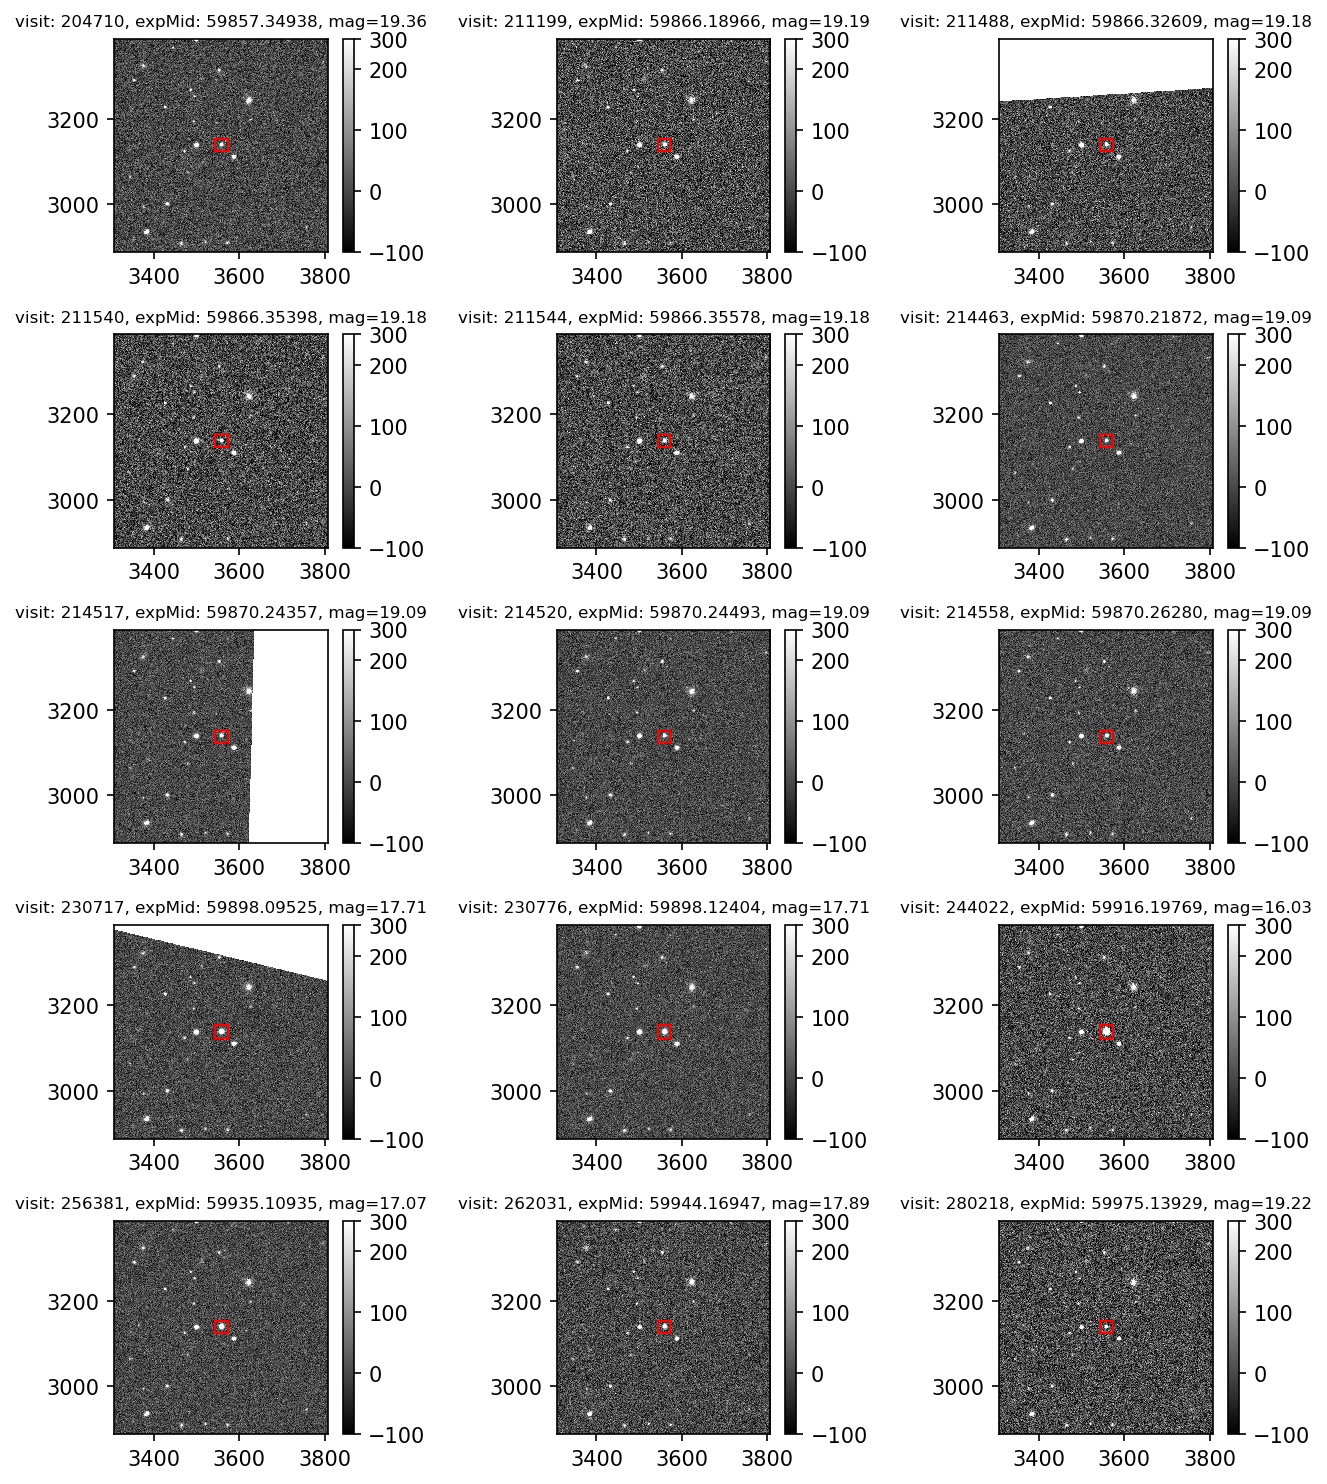

In [26]:
# Plotting

# def plot_calexp(img, fig=None, title=None, cut_center=None):
#     if fig == None:
#         fig = plt.figure()
#     display0 = afwDisplay.Display(frame=fig)
#     # display0.scale('linear', 'zscale')
#     display0.scale('linear', min=-100, max=250)
#     try:
#         display0.mtv(img.image)
#         plt.title(title)
#         if cut_center!=None:
#             x_ref = cut_center[0]
#             y_ref = cut_center[1]
#             rect = patches.Rectangle((x_ref - 15, y_ref - 15), 30, 30, linewidth=1, edgecolor='r', facecolor='none')
#             ax.add_patch(rect)
                  # fig = plt.figure()
            # display0 = afwDisplay.Display(frame=fig)
            # display0.scale('linear', min=-100, max=250)
            # display0.mtv(img.image)
    # ax = plt.subplot(projection=WCS(calexp.getWcs().getFitsMetadata()))
    
    # calexp_extent = (calexp.getBBox().beginX, calexp.getBBox().endX,
    #                  calexp.getBBox().beginY, calexp.getBBox().endY)
    
    # im = ax.imshow(calexp.image.array, cmap='gray', vmin=-200.0, vmax=400,
    #                extent=calexp_extent, origin='lower')
    
    # ax.grid(color='white', ls='--', lw=0.2)
    
    # ax.set_xlabel('Right Ascension')
    # ax.set_ylabel('Declination')

    # cbar = plt.colorbar(im, ax=ax)
    # cbar.set_label('Intensity')

    # ra1 = ax.coords[0]
    # dec1 = ax.coords[1]
    # ra1.set_ticks(spacing=1 * u.arcmin)  # Ajustar el espaciamiento en el eje de ascensión recta
    # dec1.set_ticks(spacing=1 * u.arcmin)   # Ajustar el espaciamiento en el eje de declinación
# Usar esto para armar el auto ajuste de los ticks:
#  x0 = float(cutout_image.getX0())
# y0 = float(cutout_image.getY0())
# width = cutout_image.getWidth()
# height = cutout_image.getHeight()



import matplotlib.patches as patches
fig, axs = plt.subplots(5, 3, figsize=(9, 10), dpi=150)

for i, ax in enumerate(fig.axes):
    plt.sca(ax)
    display0 = afwDisplay.Display(frame=fig)
    # display0.scale('linear', 'zscale')
    display0.scale('linear', min=-100, max=250)
    # try:
    display0.mtv(imgs[i].image)
    vis = dataids[i]['visit']
    mjd = mjd_mid_times[i]
    mag = mags_injected[i]
    plt.title(f'visit: {vis}, expMid: {mjd:0.5F}, mag={mag:0.2F}', fontsize=8)
    xy = imgs[i].getWcs().skyToPixel(geom.SpherePoint(ra*geom.degrees, dec*geom.degrees))
    x_ref = int(np.round(xy.x))
    y_ref = int(np.round(xy.y))
    rect = patches.Rectangle((x_ref - 15, y_ref - 15), 30, 30, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    # except:
    #     print('skip index ', i)

plt.tight_layout()
plt.show()

In [ ]:
# Gift

# Create the GIF
import imageio
import matplotlib.patches as patches



filenames = []
for i in range(len(cutouts)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    ax1.plot(mjd_mid_times[:i+1], mags_injected[:i+1], 'bo-')
    ax1.set_xlabel('expMid')
    ax1.set_ylabel('mag')
    ax1.set_title(f'Microlensing [Pacz t_0={t_0}, t_E={t_E}, u_0={u_0}]', fontsize=10)
    ax1.set_xlim(min(mjd_mid_times), max(mjd_mid_times))
    ax1.set_ylim(min(mags_injected) - 0.5, max(mags_injected) + 0.5)
    ax1.invert_yaxis()
    t_aux = t[t<max(mjd_mid_times[:i+1])]
    ax1.plot(t_aux, uLens_P[:len(t_aux)], "Gray")

    display0 = afwDisplay.Display(frame=fig)
    display0.scale('linear', min=-100, max=250)
    display0.mtv(cutouts[i].image)
    vis = dataids[i]['visit']
    mjd = mjd_mid_times[i]
    mag = mags_injected[i]
    ax2.set_title(f'{i}. visit: {vis}, expMid: {mjd:0.5F}, mag={mag:0.2F}', fontsize=8)

    rect = patches.Rectangle((x_ref - 15, y_ref - 15), 30, 30, linewidth=1, edgecolor='r', facecolor='none')
    ax2.add_patch(rect)
    plt.tight_layout()
    
    ax2.axis('off')
    filename = f'frame_{i}.png'
    plt.savefig(filename, bbox_inches='tight')
    filenames.append(filename)
    plt.close()

with imageio.get_writer('output.gif', mode='I', duration=500) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Remove the temporary files
import os
for filename in filenames:
    os.remove(filename)

## Search sources

In [37]:
import gc
def get_calexp_corners(calexp, degrees=True):
    x0 = float(calexp.getX0())
    y0 = float(calexp.getY0())
    width = calexp.getWidth()
    height = calexp.getHeight()
    
    xcorners = [x0, x0+width, x0+width, x0]
    ycorners = [y0, y0, y0+width, y0+width]
    if degrees:
        ra_corners = []
        dec_corners = []
        for i in range(len(xcorners)):
            radec = wcs.pixelToSky(xcorners[i], ycorners[i])
            ra_corners.append(radec.getRa().asDegrees())
            dec_corners.append(radec.getDec().asDegrees())
        return ra_corners, dec_corners
    return xcorners, ycorners 
    
def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                              dataId=coaddId)
      # Add rectangle to indicate cutout region
    from matplotlib.patches import Rectangle
    plt.gca().add_patch(Rectangle((xy.getX() - cutoutSideLength // 2, 
                                   xy.getY() - cutoutSideLength // 2),
                                   cutoutSideLength, cutoutSideLength, 
                                   linewidth=1, edgecolor='r', facecolor='none'))


    return cutout_image

def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector

def plot_image(coadd, remove = False):
    fig, ax = plt.subplots()
    display = afwDisplay.Display(frame=fig)
    display.scale('asinh', 'zscale')
    display.mtv(coadd.image)
    # plot injected calexp
    # rect = patches.Rectangle((x_ref - 15, y_ref - 15), 30, 30, linewidth=1, edgecolor='r', facecolor='none')
    # ax.add_patch(rect)
    # xy = geom.PointI(coadd.skyToPixel(radec))
    
    # plt.gca().add_patch(Rectangle((xy.getX() - cutoutSideLength // 2, 
    #                                xy.getY() - cutoutSideLength // 2),
    #                                cutoutSideLength, cutoutSideLength, 
    #                                linewidth=1, edgecolor='r', facecolor='none'))

    plt.show()
    plt.close(fig)

    plt.show()
    if remove:
        remove_figure(fig)
    else:
        return display


def pxl_to_sky(px_x, px_y, wcs):
    radec = wcs.pixelToSky(14500, 10000)
    ra, dec = radec.getRa().asDegrees(), radec.getDec().asDegrees()
    return ra, dec

def get_obj(cutout_image, plot = True):
    ra_corners, dec_corners = get_calexp_corners(cutout_image, degrees=True)
    service = get_tap_service("tap")
    query = (
        "SELECT objectId, coord_ra, coord_dec, i_extendedness, x, y, tract, patch " +
        "FROM dp02_dc2_catalogs.Object " +
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " +
        "POLYGON('ICRS', " + str(ra_corners[0]) + ", " + str(dec_corners[0]) + ", " +
        str(ra_corners[1]) + ", " + str(dec_corners[1]) + ", " +
        str(ra_corners[2]) + ", " + str(dec_corners[2]) + ", " +
        str(ra_corners[3]) + ", " + str(dec_corners[3]) + ")) = 1 AND " +
        "tract = " + str(dataId['tract']) + " AND patch = " + str(dataId['patch'])+ " AND i_extendedness = 1"
    )
    results = service.search(query).to_table()
    if plot:
        display = plot_image(cutout_image)
        with display.Buffering():
            for i in range(len(tab)):
                display.dot('+', tab[i]['x'], tab[i]['y'])#, ctype=afwDisplay.RED)
                # display.dot('o', tab[i]['x'], tab[i]['y'], size=float(tab["i_extendedness"][i])*10, ctype='orange')
        plt.show()
    return results


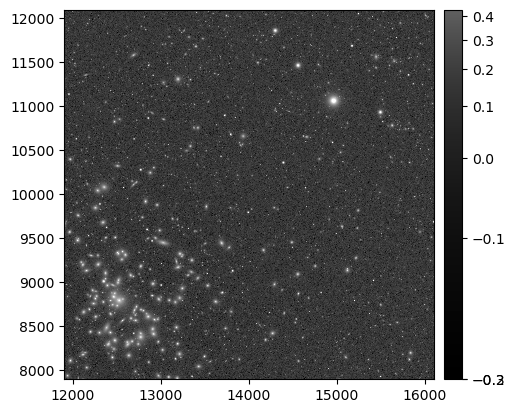

55.61927971500151 -32.205632369440025
The size of the cutout in pixels is:  (501, 501)


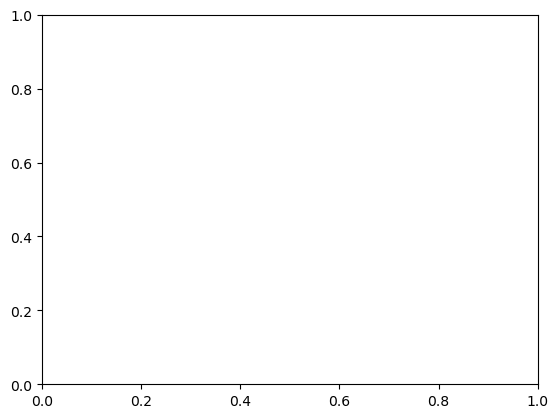

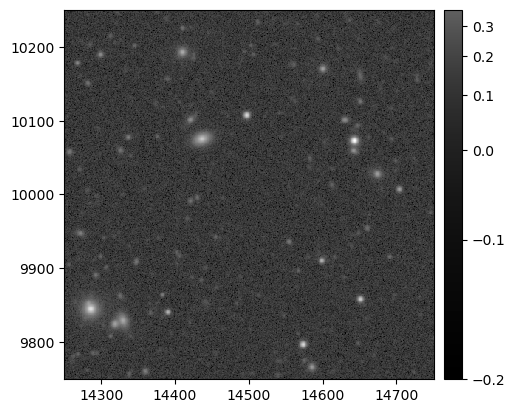

NameError: name 'cu' is not defined

In [46]:
# Add rectangle to indicate cutout region
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
 
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                              dataId=coaddId)
      # Add rectangle to indicate cutout region
    from matplotlib.patches import Rectangle
    plt.gca().add_patch(Rectangle((xy.getX() - cutoutSideLength // 2, 
                                   xy.getY() - cutoutSideLength // 2),
                                   cutoutSideLength, cutoutSideLength, 
                                   linewidth=1, edgecolor='r', facecolor='none'))


    return cutout_image

dataId = {'tract': 4431, 'patch': 17, 'band': 'i'}
datasetType = 'deepCoadd'
coadd = butler.get(datasetType, **dataId)

plot_image(coadd)

ra, dec = pxl_to_sky(14500, 10000, coadd.getWcs())
print(ra, dec)

cutout_image = cutout_coadd(butler, ra, dec, band='i', datasetType='deepCoadd',
                            cutoutSideLength=501)
print("The size of the cutout in pixels is: ", cutout_image.image.array.shape)

plot_image(cutout_image)


# def search_obj(cutout_image, band
wcs = cutout_image.getWcs()

ra_corners, dec_corners = get_calexp_corners(cutout_image, degrees=True)

# Searching objects in sky section

service = get_tap_service("tap")
query = (
    "SELECT objectId, coord_ra, coord_dec, i_extendedness, x, y, tract, patch " +
    "FROM dp02_dc2_catalogs.Object " +
    "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " +
    "POLYGON('ICRS', " + str(ra_corners[0]) + ", " + str(dec_corners[0]) + ", " +
    str(ra_corners[1]) + ", " + str(dec_corners[1]) + ", " +
    str(ra_corners[2]) + ", " + str(dec_corners[2]) + ", " +
    str(ra_corners[3]) + ", " + str(dec_corners[3]) + ")) = 1 AND " +
    "tract = " + str(dataId['tract']) + " AND patch = " + str(dataId['patch'])+ " AND i_extendedness = 0"
)

objects = service.search(query).to_table()

fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout_image.image)
with display.Buffering():
    for i in range(len(objects)):
        # display.dot('+', tab[i]['x'], tab[i]['y'])#, ctype=afwDisplay.RED)
        display.dot('o', objects[i]['x'], objects[i]['y'], size=10, ctype='orange')

source = objects[(objects["x"]<14600) & (objects["x"]>14590)&(objects["y"]<9950) & (objects["y"]>9900)] # x=14598.6818197	y=9909.9078571
with display.Buffering():
    for i in range(len(source)):
        # display.dot('+', tab[i]['x'], tab[i]['y'])#, ctype=afwDisplay.RED)
        display.dot('o', source[i]['x'], source[i]['y'], size=5, ctype='green')
plt.show()

In [45]:
objects

<Table length=111>
      objectId       coord_ra   coord_dec  ...       y       tract patch
                       deg         deg     ...      pix                 
       int64         float64     float64   ...    float64    int64 int64
------------------- ---------- ----------- ... ------------- ----- -----
1909948454470167896 55.6053716 -32.2108264 ...  9906.4283068  4431    17
1909948454470167823 55.6201885 -32.2178026 ...  9780.9369268  4431    17
1909948454470167951 55.6093529 -32.2056748 ...  9999.1835537  4431    17
1909948454470193405 55.6336082 -32.1921177 ... 10243.3202909  4431    17
1909948454470193410 55.6305425 -32.1918026 ... 10248.9834149  4431    17
1909948454470193314 55.6098168  -32.192988 ... 10227.5513462  4431    17
1909948454470190538 55.6112267  -32.218183 ...  9774.0432549  4431    17
1909948454470190457 55.6336379 -32.2188823 ...  9761.5498631  4431    17
1909948454470190784 55.6119454 -32.2158815 ...  9815.4741775  4431    17
                ...        ...         ... ...           ...   ...   ...
1909948454470161567 55.6047257 -32.1989901 ...  10119.479104  4431    17
1909948454470161201 55.6280061 -32.2067512 ...  9979.8957909  4431    17
1909948454470161210 55.6150256 -32.2064662 ...  9984.9696921  4431    17
1909948454470161077 55.6282809 -32.2090848 ...  9937.8921356  4431    17
1909948454470161058 55.6321902 -32.2089293 ...  9940.7030727  4431    17
1909948454470161379  55.627315 -32.2034064 ... 10040.1000255  4431    17
1909948454470161783 55.6065389 -32.1946524 ...  10197.571595  4431    17
1909948454470161672 55.6345375 -32.1957838 ... 10177.3309031  4431    17
1909948454470161668 55.6252732 -32.1969457 ... 10156.3880608  4431    17
1909948454470161904 55.6336235 -32.1921268 ... 10243.1563115  4431    17

In [ ]:
dataId = {'visit': visit, 'detector': detector}    
radec = geom.SpherePoint(ra, dec, geom.degrees)
cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)    
calexp_wcs = butler.get('calexp.wcs', **dataId)
xy = geom.PointI(calexp_wcs.skyToPixel(radec))
bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
parameters = {'bbox': bbox}
cutout_image = butler.get('calexp', parameters=parameters, **dataId)

# Display the main image with a rectangle showing the cutout region
calexp = butler.get('calexp', **dataId)
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')  # display.scale('linear', 'zscale')
display.mtv(calexp.image)

# Add rectangle to indicate cutout region
from matplotlib.patches import Rectangle
plt.gca().add_patch(Rectangle((xy.getX() - cutoutSideLength // 2, 
                               xy.getY() - cutoutSideLength // 2),
                               cutoutSideLength, cutoutSideLength, 
                               linewidth=1, edgecolor='r', facecolor='none'))

plt.show()
plt.close(fig)

In [13]:
objects[(objects["x"]<14600) & (objects["x"]>14590)&(objects["y"]<10000) & (objects["y"]>9900)] 

<Table length=2>
      objectId       coord_ra   coord_dec  ...      y       tract patch
                       deg         deg     ...     pix                 
       int64         float64     float64   ...   float64    int64 int64
------------------- ---------- ----------- ... ------------ ----- -----
1909948454470191936 55.6127878 -32.2064079 ... 9986.0076426  4431    17
1909948454470160928 55.6127984 -32.2106356 ... 9909.9078571  4431    17

### Injection up to a star

In [7]:
# ra=source["coord_ra"][0]
# dec=source["coord_dec"][0]
ra = 55.6127984	
dec = -32.2106356

exp_midpoints, visits, detectors, datasetRefs_list= calexp_from_loc(ra, dec)

t_0 = 59920  # Time of closest approach
t_E = 90  # Einstein timescale
u_0 = 0.2  # Minimum impact parameter
A0 = 21
var_mags = uLens_Pacz(exp_midpoints, t_0, t_E, u_0, A0, plot=False) 

inject_table = create_catalog(var_mags, exp_midpoints, visits, detectors)

start_ind = 0
finish_ind = 18

calexp_ref, psf_ref, phot_calib_ref, wcs_ref, xy_ref= get_calexp_data(datasetRefs_list[start_ind])
dataids, mjd_mid_times, mags_injected, imgs = inject_catalog(datasetRefs_list, inject_table, finish_ind=finish_ind, warp=True, cut=True)

(55.6127984, -32.2106356)HTM ID=9875746073439 at level=20 is bounded by a circle of radius ~0.28 arcsec.
                    Found 150 calexps
1/18


No sources to inject for visit  174602
2/18


No sources to inject for visit  177422
3/18


No sources to inject for visit  177481
4/18


No sources to inject for visit  192350
5/18


No sources to inject for visit  204595
6/18


No sources to inject for visit  211101
7/18


No sources to inject for visit  211146
8/18


KeyboardInterrupt: 

In [ ]:
x_ref = int(np.round(xy_ref.x))
y_ref = int(np.round(xy_ref.y))
import matplotlib.patches as patches
fig, axs = plt.subplots(5, 3, figsize=(9, 10), dpi=150)

for i, ax in enumerate(fig.axes):
    plt.sca(ax)
    display0 = afwDisplay.Display(frame=fig)
    # display0.scale('linear', 'zscale')
    display0.scale('linear', min=-100, max=250)
    # try:
    display0.mtv(imgs[i].image)
    vis = dataids[i]['visit']
    mjd = mjd_mid_times[i]
    mag = mags_injected[i]
    plt.title(f'visit: {vis}, expMid: {mjd:0.5F}, mag={mag:0.2F}',
              fontsize=8)
    rect = patches.Rectangle((x_ref - 15, y_ref - 15), 30, 30, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    # except:
    #     print('skip index ', i)

plt.tight_layout()
plt.show()

### Tests

In [ ]:
service = get_tap_service("tap")
query = (
    "SELECT id, ra, dec, redshift, is_variable, is_pointsource, flux_i, "
    "scisql_nanojanskyToAbMag(flux_i) as mag_i "
    "FROM dp02_dc2_catalogs.TruthSummary "
    "WHERE CONTAINS(POINT('ICRS', ra, dec), "
    "POLYGON('ICRS', " + str(ra_corners[0]) + ", " + str(dec_corners[0]) + ", " +
    str(ra_corners[1]) + ", " + str(dec_corners[1]) + ", " +
    str(ra_corners[2]) + ", " + str(dec_corners[2]) + ", " +
    str(ra_corners[3]) + ", " + str(dec_corners[3]) + ")) = 1"
)
truth = service.search(query).to_table().to_pandas()
all([objects["objectId"][i] in truth["id"] for i in range(111)]) # False
calexp = cutout_image
from astropy.wcs import WCS
fig = plt.figure()
plt.subplot(projection=WCS(calexp.getWcs().getFitsMetadata()))
calexp_extent = (calexp.getBBox().beginX, calexp.getBBox().endX,
                 calexp.getBBox().beginY, calexp.getBBox().endY)
im = plt.imshow(calexp.image.array, cmap='gray', vmin=-1.0, vmax=1,
                extent=calexp_extent, origin='lower')
# plt.plot(truth["ra"], truth["dec"], ".")
plt.grid(color='white', ls='--', lw=0.2)
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.show()
remove_figure(fig)

In [ ]:
plt.plot(truth["ra"], truth["dec"], ".", label = "TrurhSummary")
plt.plot(objects["coord_ra"], objects["coord_dec"], ".", label = "Objects")
plt.legend()

In [ ]:
all([objects["objectId"][i] in truth["id"] for i in range(111)])

In [ ]:
numbers = np.arange(len(results)+1)
np.random.seed(51)
np.random.shuffle(numbers)
tab = results[numbers[:11]]
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout_image.image)
with display.Buffering():
    for i in range(len(tab)):
        # display.dot('+', tab[i]['x'], tab[i]['y'], ctype=afwDisplay.RED)
        display.dot('o', tab[i]['x'], tab[i]['y'], size=30, ctype='orange')
plt.show()

GPT

In [28]:
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.geom as geom
from lsst.source.injection import VisitInjectConfig, VisitInjectTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.afw.table import SourceCatalog
from tqdm import tqdm
import matplotlib.patches as patches


# Configuración inicial
butler_config = 'dp02'
collections = '2.2i/runs/DP0.2'
butler = Butler(butler_config, collections=collections)
afwDisplay.setDefaultBackend('matplotlib')

ra = 55.6127984	
dec = -32.2106356
level=20
band = "i"
exp_midpoints, visits, detectors, datasetRefs_list= calexp_from_loc(ra, dec)
t_0 = 59920  # Time of closest approach
t_E = 90  # Einstein timescale
u_0 = 0.2  # Minimum impact parameter
A0 = 23
var_mags = uLens_Pacz(exp_midpoints, t_0, t_E, u_0, A0, plot=False) 
t = np.linspace(min(exp_midpoints), max(exp_midpoints), 1000) 
uLens_P = uLens_Pacz(t, t_0, t_E, u_0, A0)

inject_table = create_catalog(var_mags, exp_midpoints, visits, detectors)

# Listas para guardar los resultados
dataids = []
mjd_mid_times = []
mags_injected = []
fluxs = []
flux_errs = []
mags_measured = []
mags_errors = []


# Configuración de la tarea de inyección
inject_config = VisitInjectConfig()
inject_task = VisitInjectTask(config=inject_config)

schema = afwTable.SourceTable.makeMinimalSchema()


# Configuración de la tarea de detección
config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 4
config.thresholdType = "stdev"
detect_task = SourceDetectionTask(schema=schema, config=config)
del config
# Configuración de la tarea de medición

measure_config = SingleFrameMeasurementTask.ConfigClass()
measure_task = SingleFrameMeasurementTask(schema=schema, config=measure_config)
del measure_config

sourceDeblendTask = SourceDeblendTask(schema=schema)

# Generación de calexp y proceso de inyección, detección y medición
htm_id = calculate_htm_ids(ra, dec, level=level)
datasetRefs = butler.registry.queryDatasets("calexp", htm20=htm_id, where=f"band = '{band}'")
datasetRefs_list = [ref for ref in datasetRefs]
tab = afwTable.SourceTable.make(schema)
filenames = []
calexp_ref, psf_ref, phot_calib_ref, wcs_ref, xy_ref = get_calexp_data(datasetRefs_list[0])
for i, ds in enumerate(datasetRefs_list):
    if i == 40:
        break
    print(f'{i+1}/{len(datasetRefs_list)}')
    # try:
                # Guardar resultados
    mjd_mid_times.append(inject_table[i]['exp_midpoint'])
    mags_injected.append(inject_table[i]['mag'])
    # Obtener datos de calexp
    calexp, psf, phot_calib, wcs, xy = get_calexp_data(ds)
    # Inyectar la fuente
    injected_output = inject_task.run(injection_catalogs=[inject_table[i]],
                                      input_exposure=calexp.clone(),
                                      psf=psf,
                                      photo_calib=phot_calib,
                                      wcs=wcs)
    injected_exposure = injected_output.output_exposure
    injected_exposure.mask.removeAndClearMaskPlane('DETECTED')

    
    # Detectar fuentes
    detect_result = detect_task.run(tab, injected_exposure)
    sources = detect_result.sources
    sources.asAstropy()
    
    # Medir fotometría
    measure_task.run(measCat=sources, exposure=injected_exposure)
    

    
    # Encontrar la fuente inyectada en los resultados
    for source in sources:
        if source.get('coord_ra') == ra and source.get('coord_dec') == dec:
            fluxes_measured.append(source.get('flux'))
            print("Founded")
            break


    flux = source.get('base_CircularApertureFlux_4_5_instFlux')
    flux_err = source.get('base_CircularApertureFlux_4_5_instFluxErr')
    mag, mag_err = flux_to_mag(flux, flux_err, 23.9)
    
    mags_measured.append(mag)
    mags_errors.append(mag_err)
    fluxs.append(flux)
    flux_errs.append(flux_err)
    dataids.append(ds.dataId)
    sources.asAstropy()
    img = warp_img(calexp_ref, injected_exposure, wcs_ref, wcs)
    xy = img.getWcs().skyToPixel(geom.SpherePoint(ra*geom.degrees, dec*geom.degrees))
    x = int(np.round(xy.x))
    y = int(np.round(xy.y))
    img = cutout(img, x, y, 801)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    ax1.plot(mjd_mid_times[:i+1], mags_injected[:i+1], 'bo', label="Injected")
    ax1.errorbar(mjd_mid_times[:i+1], mags_measured[:i+1], yerr=mags_errors[:i+1], fmt='ro', label="Measured") ##
    ax1.set_xlabel('expMid')
    ax1.set_ylabel('mag')
    ax1.set_title(f'Microlensing [Pacz t_0={t_0}, t_E={t_E}, u_0={u_0}]', fontsize=10)
    ax1.set_xlim(min(mjd_mid_times), max(mjd_mid_times))
    # ax1.set_ylim(min([min(mags_measured),min(mags_injected)])  - 0.5, max([max(mags_measured),max(mags_injected)])  + 0.5)
    ax1.invert_yaxis()
    t_aux = t[t<max(mjd_mid_times[:i+1])]
    ax1.plot(t_aux, uLens_P[:len(t_aux)], "Gray", label = "Pacz")
    ax1.legend()

    display0 = afwDisplay.Display(frame=fig)
    display0.scale('linear', min=-100, max=250)
    display0.mtv(img.image)
    vis = dataids[i]['visit']
    mjd = mjd_mid_times[i]
    mag = mags_injected[i]
    ax2.set_title(f'{i}. visit: {vis}, expMid: {mjd:0.5F}, mag={mag:0.2F}', fontsize=8)

    rect = patches.Rectangle((x - 15, y - 15), 30, 30, linewidth=1, edgecolor='r', facecolor='none')
    ax2.add_patch(rect)
    plt.tight_layout()
    
    ax2.axis('off')
    filename = f'frame_{i}.png'
    plt.savefig(filename, bbox_inches='tight')
    filenames.append(filename)
    plt.close()
    print(f"Injeted: {inject_table[i]["mag"]} | Measured: {mag} | Error: {mag_err}")
    
    # except Exception as e:
    #     print(f'Error en el procesamiento del dataset {ds.dataId}: {e}')
    # Borrar datos no necesarios para ahorrar espacio de RAM
    del calexp, injected_exposure, sources, detect_result



                    Found 150 calexps
1/150


1.33208176568235
<class 'numpy.float64'>


/tmp/ipykernel_1668/1992856870.py:133: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax1.set_xlim(min(mjd_mid_times), max(mjd_mid_times))


2/150


0.07024764631882796
<class 'numpy.float64'>
3/150


0.31674691580708725
<class 'numpy.float64'>
4/150


0.6566864925887845
<class 'numpy.float64'>
5/150


0.2999913332352513
<class 'numpy.float64'>
6/150


0.45342413886014654
<class 'numpy.float64'>
7/150


KeyboardInterrupt: 

In [27]:
mjd_mid_times, fluxs, flux_errs, mags_measured,  mags_injected, mags_errors
# type(mjd_mid_times[:i+1][0]), type(mags_measured[:i+1][0]), type(mags_errors[:i+1][0])

([59810.38177622454,
  59813.364076224534,
  59813.39967922338,
  59837.38009422338,
  59857.28728422338,
  59866.14436522106],
 [777.4383544921875,
  11826.08203125,
  2597.90185546875,
  1905.6005859375,
  3409.9140625,
  2673.8544921875],
 [424.90533447265625,
  382.4430847167969,
  376.2840576171875,
  559.3372192382812,
  468.10833740234375,
  550.3507690429688],
 [16.67333509374406,
  13.717897782140763,
  15.363443149740874,
  15.699920305809068,
  15.068141415167094,
  15.332155575481886],
 [24.285360841938235,
  24.271628209764966,
  24.271457976139693,
  24.111455581043618,
  23.86237003522865,
  23.687625781559998],
 [1.3320720667363872,
  0.07024763470904993,
  0.31674691580708725,
  0.6566898434857702,
  0.29999081116560156,
  0.45342413886014654])

In [33]:
mjd_mid_times, fluxs, flux_errs, mags_measured,  mags_injected, mags_errors
# type(mjd_mid_times[:i+1][0]), type(mags_measured[:i+1][0]), type(mags_errors[:i+1][0])

([59810.38177622454,
  59813.364076224534,
  59813.39967922338,
  59837.38009422338,
  59857.28728422338,
  59866.14436522106],
 [777.4338989257812,
  11826.080078125,
  2597.90185546875,
  1905.6097412109375,
  3409.908203125,
  2673.8544921875],
 [424.90533447265625,
  382.4430847167969,
  376.2840576171875,
  559.3372192382812,
  468.10833740234375,
  550.3507690429688],
 [16.673341316209925,
  13.71789796145448,
  15.363443149740874,
  15.699915089507169,
  15.06814328082732,
  15.332155575481886],
 [21.785360841938235,
  21.771628209764966,
  21.771457976139693,
  21.611455581043618,
  21.36237003522865,
  21.187625781559998],
 [1.33208176568235,
  0.07024764631882796,
  0.31674691580708725,
  0.6566864925887845,
  0.2999913332352513,
  0.45342413886014654])

21.1871366860908

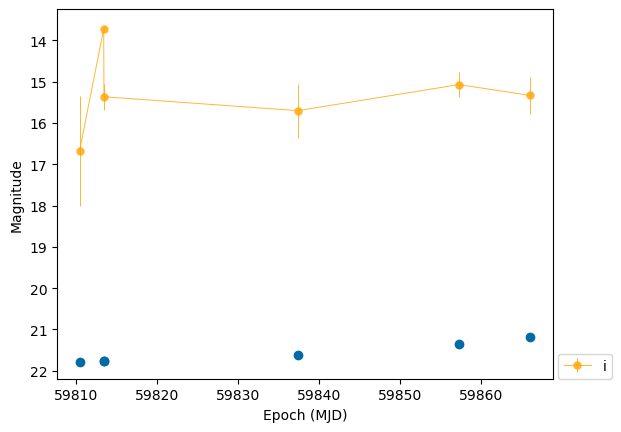

In [32]:

fig, ax = plot_event({"i":{"mjd": mjd_mid_times, "mag": mags_measured, "mag_err":mags_errors}}, bands ="i", show=False) 
ax.plot(mjd_mid_times, mags_injected, "o")


In [14]:
import lsst.afw.table as afwTable
import matplotlib.pyplot as plt
from lsst.rsp import get_tap_service
import numpy as np
import os
import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord

from lsst.daf.butler import Butler
from lsst.daf.butler.registry import ConflictingDefinitionError
import lsst.afw.display as afwDisplay
import lsst.geom as geom
from lsst.source.injection import ingest_injection_catalog, generate_injection_catalog
from lsst.source.injection import VisitInjectConfig, VisitInjectTask
import lsst.sphgeom
from lsst.pipe.tasks.registerImage import RegisterConfig, RegisterTask

afwDisplay.setDefaultBackend('matplotlib')
plt.style.use('tableau-colorblind10')


butler_config = 'dp02'
collections = '2.2i/runs/DP0.2'
butler = Butler(butler_config, collections=collections)
from lsst.meas.deblender import SourceDeblendTask

def calculate_htm_ids(ra, dec, level=20):
    pixelization = lsst.sphgeom.HtmPixelization(level)
    htm_id = pixelization.index(lsst.sphgeom.UnitVector3d(lsst.sphgeom.LonLat.fromDegrees(ra, dec)))
    return htm_id

def flux_to_mag(Flux, Flux_err = "", F0=23.9):
    '''Use numpy arrays, no list'''
    if type(Flux_err) != str:
        top = Flux + Flux_err
        bot = Flux - Flux_err
        top_mag = F0 - 2.5 * np.log10(np.abs(top))
        try:
            bot_mag = F0 - 2.5 * np.log10(np.abs(bot))
        except RuntimeWarning as e:
            print(e, Flux, Flux_err)
        return F0 - 2.5 * np.log10(np.abs(Flux)), np.abs(top_mag - bot_mag)
    else:
        return F0 - 2.5 * np.log10(np.abs(Flux))

def calexp_from_loc(ra, dec, band = "i", level = 20):
    htm_id = calculate_htm_ids(ra, dec)
    datasetRefs = butler.registry.queryDatasets("calexp", htm20=htm_id,
                                                where=f"band = '{band}'")
    datasetRefs_list = [ref for ref in datasetRefs]
        # Example: ref = DatasetRef(DatasetType('calexp', {band, instrument, detector, physical_filter, visit_system, visit}, ExposureF), 
        # {instrument: 'LSSTCam-imSim', detector: 106, visit: 1231987, band: 'i', 
        # physical_filter: 'i_sim_1.4', visit_system: 1}, run='2.2i/runs/DP0.2/v23_0_0_rc5/PREOPS-905/20220104T085126Z', 
        # id=6894509b-e233-484e-b04d-416a5805c350) 
    
    print("{:<20}".format("") + f"Found {len(list(datasetRefs))} calexps")

    # From that images, save the exposure times by searching them per visit and detector in ccdVisitTable
    ccd_visit = butler.get('ccdVisitTable') # I guess this butler have an specific OpSim (observation strategy)
    exp_midpoints = []
    visits = []
    detectors = []
    
    for d in datasetRefs_list:
        did = d.dataId
        # Look up the info by visit and detector:
        ccdrow = (ccd_visit['visitId'] == did['visit']) & (ccd_visit['detector'] == did['detector'])
        exp_midpoints.append(ccd_visit[ccdrow]['expMidptMJD'].values[0])
        visits.append(did['visit'])
        detectors.append(did['detector'])
    
    exp_midpoints = np.array(exp_midpoints)
    visits = np.array(visits)
    detectors = np.array(detectors) 
    return exp_midpoints, visits, detectors, datasetRefs_list
# Get reference data ID and relevant data from the reference calexp
def get_calexp_data(datasetRef):
    ref_dataId = datasetRef.dataId
    calexp_ref = butler.get('calexp', dataId=ref_dataId)
    psf_ref = calexp_ref.getPsf()
    phot_calib_ref = calexp_ref.getPhotoCalib()
    wcs_ref = calexp_ref.getWcs()
    xy_ref = wcs_ref.skyToPixel(geom.SpherePoint(ra*geom.degrees, dec*geom.degrees))  # Convert reference RA and Dec to pixel coordinates
    # x_ref = int(np.round(xy_ref.x))
    # y_ref = int(np.round(xy_ref.y))
    return calexp_ref, psf_ref, phot_calib_ref, wcs_ref, xy_ref
    
def uLens_Pacz(t, t_0, t_E, u_0, A0, plot=False):
    """
    Calculate the microlensing magnification using the Paczynski formula.
    
    Parameters:
    t (float or np.ndarray): Time(s) at which to calculate the magnification.
    t_0 (float): Time of closest approach.
    t_E (float): Einstein timescale.
    u_0 (float): Minimum impact parameter.
    
    Returns:
    float or np.ndarray: Magnification(s) at the given time(s).
    """
    u_t = np.sqrt(u_0**2 + ((t - t_0) / t_E)**2)
    A_t = A0 - (u_t**2 + 2) / (u_t * np.sqrt(u_t**2 + 4))
    if plot:
        t = np.linspace(min(exp_midpoints), max(exp_midpoints), 1000) 
        uLens_P = uLens_Pacz(t, t_0, t_E, u_0, A0)
        plt.plot(t, uLens_P, "Gray")
        plt.plot(exp_midpoints, A_t, "o")
        plt.xlabel('Time')
        plt.ylabel('Magnification')
        plt.title('Microlensing - Paczynski')
        plt.show()
    return A_t 

def create_catalog(var_mags, exp_midpoints, visits, detectors):
    ra_arr = np.full((len(var_mags)), ra)
    dec_arr = np.full((len(var_mags)), dec)
    id_arr = np.arange(0, len(var_mags), 1)
    src_type_arr = np.full((len(var_mags)), 'Star')
    
    inject_table = Table([id_arr, visits, detectors, ra_arr, dec_arr,
                          src_type_arr, exp_midpoints, var_mags],
                         names=['injection_id', 'visit', 'detector', 'ra', 'dec',
                                'source_type', 'exp_midpoint', 'mag'])
    return inject_table

def calexp_from_loc(ra, dec, band = "i", level = 20):
    htm_id = calculate_htm_ids(ra, dec)
    datasetRefs = butler.registry.queryDatasets("calexp", htm20=htm_id,
                                                where=f"band = '{band}'")
    datasetRefs_list = [ref for ref in datasetRefs]
        # Example: ref = DatasetRef(DatasetType('calexp', {band, instrument, detector, physical_filter, visit_system, visit}, ExposureF), 
        # {instrument: 'LSSTCam-imSim', detector: 106, visit: 1231987, band: 'i', 
        # physical_filter: 'i_sim_1.4', visit_system: 1}, run='2.2i/runs/DP0.2/v23_0_0_rc5/PREOPS-905/20220104T085126Z', 
        # id=6894509b-e233-484e-b04d-416a5805c350) 
    
    print("{:<20}".format("") + f"Found {len(list(datasetRefs))} calexps")

    # From that images, save the exposure times by searching them per visit and detector in ccdVisitTable
    ccd_visit = butler.get('ccdVisitTable') # I guess this butler have an specific OpSim (observation strategy)
    exp_midpoints = []
    visits = []
    detectors = []
    
    for d in datasetRefs_list:
        did = d.dataId
        # Look up the info by visit and detector:
        ccdrow = (ccd_visit['visitId'] == did['visit']) & (ccd_visit['detector'] == did['detector'])
        exp_midpoints.append(ccd_visit[ccdrow]['expMidptMJD'].values[0])
        visits.append(did['visit'])
        detectors.append(did['detector'])
    
    exp_midpoints = np.array(exp_midpoints)
    visits = np.array(visits)
    detectors = np.array(detectors) 
    return exp_midpoints, visits, detectors, datasetRefs_list

def cutout(im, xcen, ycen, size):
    '''Create a cutout of an input image array

    Parameters
    ----------
    im : ndarray
        2D image array
    xcen : int
        X center position of the cutout
    ycen : int
        Y center position of the cutout
    size : int
        Width in pixels of the resulting image
    '''
    # Calculate half size
    half_size = size // 2

    # Ensure the cutout is within the image boundaries
    x_start = max(xcen - half_size, 0)
    x_end = min(xcen + half_size, im.width)
    y_start = max(ycen - half_size, 0)
    y_end = min(ycen + half_size, im.height)

    return im[y_start:y_end, x_start:x_end]

def warp_img(ref_img, img_to_warp, ref_wcs, wcs_to_warp):
    '''Warp an image to the same orientation as a reference image

    Parameters
    ----------
    ref_img: `ExposureF`
        Reference image to warp to
    img_to_warp: `ExposureF`
        Image to warp to the reference orientation
    ref_wcs: `WCS` object
        WCS of the reference image
    wcs_to_warp: `WCS` object
        WCS of the input image to be warped
    '''

    config = RegisterConfig()
    task = RegisterTask(name="register", config=config)
    warpedExp = task.warpExposure(img_to_warp, wcs_to_warp, ref_wcs,
                                  ref_img.getBBox())

    return warpedExp

def plot_event(event_dic, bands="ugrizy", title="", median=False, plot_mags=False, ax=None, show=True):
    bands_colors = {'u': 'b', 'g': 'c', 'r': 'g', 'i': 'orange', 'z': 'r', 'y': 'm'}
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    for band in bands:
        lc = event_dic[band.lower()]
        ax.errorbar(lc["mjd"], lc["mag"], lc["mag_err"], color=bands_colors[band.lower()], marker='o', alpha=0.8,
                    mew=0.05, lw=0.7, label=band[0])
        ax.invert_yaxis()
        ax.set_xlabel("Epoch (MJD)")
        ax.set_ylabel("Magnitude")
        ax.set_title(title)
        if median:
            ax.hlines(np.median(lc["mag"]), xmin=min(lc["mjd"]), xmax=max(lc["mjd"]), linestyle='--',
                      color=bands_colors[band.lower()], label=f"median {band}")
        if isinstance(plot_mags, list):
            for (m, name) in plot_mags:
                ax.hlines(m[band.lower()], xmin=min(lc["mjd"]), xmax=max(lc["mjd"]), color=bands_colors[band.lower()],
                          label=f"{name} {band}")
        ax.legend(loc=(1.01, 0))
    if show:
        plt.show()
    return fig, ax



In [34]:
names = """id: 1961
coord_ra: 1.08471 rad
coord_dec: -0.624758 rad
parent: 0
base_SdssCentroid_x: 3558.55
base_SdssCentroid_y: 3139.68
base_SdssCentroid_xErr: 0.748011
base_SdssCentroid_yErr: 0.484211
base_SdssCentroid_flag: 0
base_SdssCentroid_flag_edge: 0
base_SdssCentroid_flag_noSecondDerivative: 0
base_SdssCentroid_flag_almostNoSecondDerivative: 0
base_SdssCentroid_flag_notAtMaximum: 0
base_SdssCentroid_flag_near_edge: 0
base_SdssCentroid_flag_resetToPeak: 0
base_SdssCentroid_flag_badError: 0
base_Blendedness_old: 0
base_Blendedness_raw: 0
base_Blendedness_raw_child_instFlux: 2624.21
base_Blendedness_raw_parent_instFlux: 2624.21
base_Blendedness_abs: 0
base_Blendedness_abs_child_instFlux: 2792.09
base_Blendedness_abs_parent_instFlux: 2792.09
base_Blendedness_raw_child_xx: 4.73011
base_Blendedness_raw_child_yy: 3.14119
base_Blendedness_raw_child_xy: 0.374129
base_Blendedness_raw_parent_xx: 4.73011
base_Blendedness_raw_parent_yy: 3.14119
base_Blendedness_raw_parent_xy: 0.374129
base_Blendedness_abs_child_xx: 5.85048
base_Blendedness_abs_child_yy: 4.24727
base_Blendedness_abs_child_xy: 0.912528
base_Blendedness_abs_parent_xx: 5.85048
base_Blendedness_abs_parent_yy: 4.24727
base_Blendedness_abs_parent_xy: 0.912528
base_Blendedness_flag: 0
base_Blendedness_flag_noCentroid: 0
base_Blendedness_flag_noShape: 0
base_SdssShape_xx: 4.68674
base_SdssShape_yy: 3.19287
base_SdssShape_xy: 0.384664
base_SdssShape_xxErr: 1.60447
base_SdssShape_yyErr: 1.09305
base_SdssShape_xyErr: 0.941038
base_SdssShape_x: 3558.66
base_SdssShape_y: 3139.63
base_SdssShape_instFlux: 2658.17
base_SdssShape_instFluxErr: 455
base_SdssShape_psf_xx: 2.51062
base_SdssShape_psf_yy: 2.46139
base_SdssShape_psf_xy: 0.0319984
base_SdssShape_instFlux_xx_Cov: -365.016
base_SdssShape_instFlux_yy_Cov: -248.669
base_SdssShape_instFlux_xy_Cov: -29.9587
base_SdssShape_flag: 0
base_SdssShape_flag_unweightedBad: 0
base_SdssShape_flag_unweighted: 0
base_SdssShape_flag_shift: 0
base_SdssShape_flag_maxIter: 0
base_SdssShape_flag_psf: 0
base_CircularApertureFlux_3_0_instFlux: 1864.14
base_CircularApertureFlux_3_0_instFluxErr: 244.198
base_CircularApertureFlux_3_0_flag: 0
base_CircularApertureFlux_3_0_flag_apertureTruncated: 0
base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated: 0
base_CircularApertureFlux_4_5_instFlux: 2569.55
base_CircularApertureFlux_4_5_instFluxErr: 366.374
base_CircularApertureFlux_4_5_flag: 0
base_CircularApertureFlux_4_5_flag_apertureTruncated: 0
base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated: 0
base_CircularApertureFlux_6_0_instFlux: 2521
base_CircularApertureFlux_6_0_instFluxErr: 490.688
base_CircularApertureFlux_6_0_flag: 0
base_CircularApertureFlux_6_0_flag_apertureTruncated: 0
base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated: 0
base_CircularApertureFlux_9_0_instFlux: 2398.64
base_CircularApertureFlux_9_0_instFluxErr: 740.194
base_CircularApertureFlux_9_0_flag: 0
base_CircularApertureFlux_9_0_flag_apertureTruncated: 0
base_CircularApertureFlux_9_0_flag_sincCoeffsTruncated: 0
base_CircularApertureFlux_12_0_instFlux: 2392.56
base_CircularApertureFlux_12_0_instFluxErr: 1000.98
base_CircularApertureFlux_12_0_flag: 0
base_CircularApertureFlux_12_0_flag_apertureTruncated: 0
base_CircularApertureFlux_17_0_instFlux: 2458.66
base_CircularApertureFlux_17_0_instFluxErr: 1416.49
base_CircularApertureFlux_17_0_flag: 0
base_CircularApertureFlux_17_0_flag_apertureTruncated: 0
base_CircularApertureFlux_25_0_instFlux: 1853.4
base_CircularApertureFlux_25_0_instFluxErr: 2082.24
base_CircularApertureFlux_25_0_flag: 0
base_CircularApertureFlux_25_0_flag_apertureTruncated: 0
base_CircularApertureFlux_35_0_instFlux: -1135.5
base_CircularApertureFlux_35_0_instFluxErr: 2912.91
base_CircularApertureFlux_35_0_flag: 0
base_CircularApertureFlux_35_0_flag_apertureTruncated: 0
base_CircularApertureFlux_50_0_instFlux: 381.094
base_CircularApertureFlux_50_0_instFluxErr: 4186.01
base_CircularApertureFlux_50_0_flag: 0
base_CircularApertureFlux_50_0_flag_apertureTruncated: 0
base_CircularApertureFlux_70_0_instFlux: -5282.57
base_CircularApertureFlux_70_0_instFluxErr: 5877.47
base_CircularApertureFlux_70_0_flag: 0
base_CircularApertureFlux_70_0_flag_apertureTruncated: 0
base_ClassificationSizeExtendedness_value: 0.572661
base_ClassificationSizeExtendedness_flag: 0
base_CompensatedGaussianFlux_flag: 0
base_CompensatedGaussianFlux_bounds_flag: 0
base_CompensatedGaussianFlux_3_instFlux: 4203.08
base_CompensatedGaussianFlux_3_instFluxErr: 557.315
base_CompensatedGaussianFlux_3_mask_bits: 28704
base_CompensatedGaussianFlux_5_instFlux: 5472.83
base_CompensatedGaussianFlux_5_instFluxErr: 930.061
base_CompensatedGaussianFlux_5_mask_bits: 61472
base_GaussianFlux_instFlux: 2658.17
base_GaussianFlux_instFluxErr: 327.012
base_GaussianFlux_flag: 0
base_LocalBackground_instFlux: 0.677776
base_LocalBackground_instFluxErr: 46.6566
base_LocalBackground_flag: 0
base_LocalBackground_flag_noGoodPixels: 0
base_LocalBackground_flag_noPsf: 0
base_PixelFlags_flag: 0
base_PixelFlags_flag_offimage: 0
base_PixelFlags_flag_edge: 0
base_PixelFlags_flag_interpolated: 0
base_PixelFlags_flag_saturated: 0
base_PixelFlags_flag_cr: 0
base_PixelFlags_flag_bad: 0
base_PixelFlags_flag_suspect: 0
base_PixelFlags_flag_edgeCenter: 0
base_PixelFlags_flag_interpolatedCenter: 0
base_PixelFlags_flag_saturatedCenter: 0
base_PixelFlags_flag_crCenter: 0
base_PixelFlags_flag_badCenter: 0
base_PixelFlags_flag_suspectCenter: 0
base_PixelFlags_flag_edgeCenterAll: 0
base_PixelFlags_flag_interpolatedCenterAll: 0
base_PixelFlags_flag_saturatedCenterAll: 0
base_PixelFlags_flag_crCenterAll: 0
base_PixelFlags_flag_badCenterAll: 0
base_PixelFlags_flag_suspectCenterAll: 0
base_PsfFlux_instFlux: 2222.77
base_PsfFlux_instFluxErr: 281.34
base_PsfFlux_area: 36.2826
base_PsfFlux_chi2: 1744.49
base_PsfFlux_npixels: 1681
base_PsfFlux_flag: 0
base_PsfFlux_flag_noGoodPixels: 0
base_PsfFlux_flag_edge: 0
base_Variance_flag: 0
base_Variance_value: 2202.1
base_Variance_flag_emptyFootprint: 0
deblend_nChild: 0
deblend_deblendedAsPsf: 0
deblend_psfCenter_x: nan
deblend_psfCenter_y: nan
deblend_psf_instFlux: nan
deblend_tooManyPeaks: 0
deblend_parentTooBig: 0
deblend_masked: 0
deblend_failed: 0
deblend_skipped: 0
deblend_rampedTemplate: 0
deblend_patchedTemplate: 0
deblend_hasStrayFlux: 0
deblend_peak_center_x: 0
deblend_peak_center_y: 0
deblend_peakId: 0
deblend_nPeaks: 0
deblend_parentNPeaks: 0"""

In [35]:
names = names.split("\n")
names = [name.split(":")[0] for name in names]
names = [name.split("_") for name in names]

In [36]:
none = [name for name in names if (not "base" in name) and (not "deblend" in name)]

In [37]:
base = [name[1:] for name in names if name[0] == "base"]
deb = [name[1:] for name in names if name[0] == "deblend"]
# len(base)+len(none)+len(deb) == len(names)

In [38]:
base0 = [name[0] for name in base]
# base0 = [name[0] for name in base0]

In [39]:
names = """id: 1961
coord_ra: 1.08471 rad
coord_dec: -0.624758 rad
parent: 0
base_SdssCentroid_x: 3558.55
base_SdssCentroid_y: 3139.68"""
names = names.split("\n")
names = [name.split(":")[0] for name in names]
names = [name.split("_") for name in names]
none = [name for name in names if (not "base" in name) and (not "deblend" in name)]
base = [name[1:] for name in names if name[0] == "base"]
deb = [name[1:] for name in names if name[0] == "deblend"]
base0 = [name[0] for name in base]
Base = {}
for b in base0:
    Base[b]=[]
for subb in base:
    Base[subb[0]].append(subb[1:])

In [10]:
import matplotlib.pyplot as plt
from lsst.rsp import get_tap_service
import numpy as np
import imageio
import pandas as pd
import os
import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord
import time
import gc
import zipfile
import sys

from lsst.daf.butler import Butler
from lsst.daf.butler.registry import ConflictingDefinitionError
import lsst.daf.base as dafBase

import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.geom as geom
import lsst.sphgeom

from lsst.source.injection import ingest_injection_catalog, generate_injection_catalog
from lsst.source.injection import VisitInjectConfig, VisitInjectTask

from lsst.pipe.tasks.registerImage import RegisterConfig, RegisterTask
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask

from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.meas.base import ForcedMeasurementTask

afwDisplay.setDefaultBackend('matplotlib')
plt.style.use('tableau-colorblind10')

butler_config = 'dp02'
collections = '2.2i/runs/DP0.2'
butler = Butler(butler_config, collections=collections)

def calculate_htm_id(ra, dec, level=20):
    pixelization = lsst.sphgeom.HtmPixelization(level)
    htm_id = pixelization.index(
        lsst.sphgeom.UnitVector3d(
            lsst.sphgeom.LonLat.fromDegrees(ra, dec)
        )
    )
    circle = pixelization.triangle(htm_id).getBoundingCircle()
    scale = circle.getOpeningAngle().asDegrees()*3600.
    level = pixelization.getLevel()
    print("{:<20}".format(f'({ra}, {dec})') + f'HTM ID={htm_id} at level={level} is bounded by a circle of radius ~{scale:0.2f} arcsec.')

    return htm_id
    
def calexp_from_loc(ra, dec, band = "i", level = 20):
    htm_id = calculate_htm_id(ra, dec, level)
    datasetRefs = butler.registry.queryDatasets("calexp", htm20=htm_id,
                                                where=f"band = '{band}'")
    datasetRefs_list = [ref for ref in datasetRefs]
        # Example: ref = DatasetRef(DatasetType('calexp', {band, instrument, detector, physical_filter, visit_system, visit}, ExposureF), 
        # {instrument: 'LSSTCam-imSim', detector: 106, visit: 1231987, band: 'i', 
        # physical_filter: 'i_sim_1.4', visit_system: 1}, run='2.2i/runs/DP0.2/v23_0_0_rc5/PREOPS-905/20220104T085126Z', 
        # id=6894509b-e233-484e-b04d-416a5805c350) 
    
    print("{:<20}".format("") + f"Found {len(list(datasetRefs))} calexps")

    # From that images, save the exposure times by searching them per visit and detector in ccdVisitTable
    ccd_visit = butler.get('ccdVisitTable') # I guess this butler have an specific OpSim (observation strategy)
    exp_midpoints = []
    visits = []
    detectors = []
    
    for d in datasetRefs_list:
        did = d.dataId
        ccdrow = (ccd_visit['visitId'] == did['visit']) & (ccd_visit['detector'] == did['detector'])
        exp_midpoints.append(ccd_visit[ccdrow]['expMidptMJD'].values[0])
        visits.append(did['visit'])
        detectors.append(did['detector'])
    
    exp_midpoints = np.array(exp_midpoints)
    visits = np.array(visits)
    detectors = np.array(detectors) 
    return exp_midpoints, visits, detectors, datasetRefs_list
    
import numpy as np
import matplotlib.pyplot as plt

def uLens_Pacz(t, t_0, t_E, u_0, m_base, plot=False):
    """
    Calculate the microlensing magnification using the Paczynski formula.
    
    Parameters:
    t (float or np.ndarray): Time(s) at which to calculate the magnification.
    t_0 (float): Time of closest approach.
    t_E (float): Einstein timescale.
    u_0 (float): Minimum impact parameter.
    m_base (float): Baseline magnitude of the source star.
    plot (bool): If True, plot the magnification curve.
    
    Returns:
    float or np.ndarray: Magnitude(s) at the given time(s).
    """
    u_t = np.sqrt(u_0**2 + ((t - t_0) / t_E)**2)
    A_t = (u_t**2 + 2) / (u_t * np.sqrt(u_t**2 + 4))
    
    # Convert magnification to magnitude
    m_t = m_base - 2.5 * np.log10(A_t)
    
    if plot:
        t_plot = np.linspace(np.min(t), np.max(t), 1000)
        A_plot = (np.sqrt(u_0**2 + ((t_plot - t_0) / t_E)**2)**2 + 2) / \
                 (np.sqrt(u_0**2 + ((t_plot - t_0) / t_E)**2) * np.sqrt(np.sqrt(u_0**2 + ((t_plot - t_0) / t_E)**2)**2 + 4))
        m_plot = m_base - 2.5 * np.log10(A_plot)
        
        plt.plot(t_plot, m_plot, color='gray')
        plt.scatter(t, m_t, color='red')
        plt.xlabel('Time')
        plt.ylabel('Magnitude')
        plt.title('Microlensing - Paczynski')
        plt.gca().invert_yaxis()  # Invert y-axis to show magnitude properly
        plt.show()
    
    return m_t

def warp_img(ref_img, img_to_warp, ref_wcs):
    '''Warp an image to the same orientation as a reference image

    Parameters
    ----------
    ref_img: `ExposureF`
        Reference image to warp to
    img_to_warp: `ExposureF`
        Image to warp to the reference orientation
    ref_wcs: `WCS` object
        WCS of the reference image
    wcs_to_warp: `WCS` object
        WCS of the input image to be warped
    '''
    wcs_to_warp = img_to_warp.getWcs()
    config = RegisterConfig()
    task = RegisterTask(name="register", config=config)
    warpedExp = task.warpExposure(img_to_warp, wcs_to_warp, ref_wcs,
                                  ref_img.getBBox())

    return warpedExp

def create_catalog(var_mags, exp_midpoints, visits, detectors):
    ra_arr = np.full((len(var_mags)), ra)
    dec_arr = np.full((len(var_mags)), dec)
    id_arr = np.arange(0, len(var_mags), 1)
    src_type_arr = np.full((len(var_mags)), 'Star')
    
    inject_table = Table([id_arr, visits, detectors, ra_arr, dec_arr,
                          src_type_arr, exp_midpoints, var_mags],
                         names=['injection_id', 'visit', 'detector', 'ra', 'dec',
                                'source_type', 'exp_midpoint', 'mag'])
    return inject_table

# Get reference data ID and relevant data from the reference calexp
def get_calexp_data(datasetRef):
    ref_dataId = datasetRef.dataId
    calexp_ref = butler.get('calexp', dataId=ref_dataId)
    psf_ref = calexp_ref.getPsf()
    phot_calib_ref = calexp_ref.getPhotoCalib()
    wcs_ref = calexp_ref.getWcs()
    xy_ref = wcs_ref.skyToPixel(geom.SpherePoint(ra*geom.degrees, dec*geom.degrees))  # Convert reference RA and Dec to pixel coordinates
    # x_ref = int(np.round(xy_ref.x))
    # y_ref = int(np.round(xy_ref.y))
    return calexp_ref, psf_ref, phot_calib_ref, wcs_ref, xy_ref

# Injection and cutting

def inject_catalog(datasetRefs_list, inject_table, start_ind=0, finish_ind=-1, warp=False, cut=False):
    imgs = []
    dataids = []
    mjd_mid_times = []
    mags_injected = []
 
    inject_config = VisitInjectConfig()
    inject_task = VisitInjectTask(config=inject_config)
    datasetRefs=datasetRefs_list[start_ind:finish_ind]
    for i, ds in enumerate(datasetRefs):
        print(f'{i+1}/{len(datasetRefs)}')
        calexp_i, psf_i, phot_calib_i, wcs_i, xy_i = get_calexp_data(ds)    
        try:
            injected_output_i = inject_task.run(
                injection_catalogs=[inject_table[i]],
                input_exposure=calexp_i.clone(),
                psf=psf_i,
                photo_calib=phot_calib_i,
                wcs=wcs_i,)
            injected_exposure_i = injected_output_i.output_exposure
            injected_catalog_i = injected_output_i.output_catalog
                
            mjd_mid_times.append(inject_table[i]['exp_midpoint'])
            mags_injected.append(inject_table[i]['mag'])
            dataids.append(ds.dataId)
    
            if warp:
                img = warp_img(calexp_ref, injected_exposure_i, wcs_ref, wcs_i)
                print("Warped")
            else:
                img = injected_exposure_i
            if cut != False:
                print("Cutting")
                ra = cut[0]
                dec = cut[1]
                xy = img.getWcs().skyToPixel(geom.SpherePoint(ra*geom.degrees, dec*geom.degrees))
                x = int(np.round(xy.x))
                y = int(np.round(xy.y))
                img = cutout(img, x, y, 301)
                print("Cut finished")
            imgs.append(img)
            print(len(imgs))
        except:
            # Some visits don't actually overlap the point where we're injecting a star
            print('No sources to inject for visit ', inject_table[i]['visit'])
    return dataids, mjd_mid_times, mags_injected, imgs

def Injection():
    inject_config = VisitInjectConfig()
    inject_task = VisitInjectTask(config=inject_config)
    return inject_task
    
def inject(calexp_data, inject_data, inject_task, fits=False):
    calexp, psf, phot_calib, wcs, xy = get_calexp_data(calexp_data)    
    try:
        injected_output = inject_task.run(
            injection_catalogs=[inject_data],
            input_exposure=calexp.clone(),
            psf=psf,
            photo_calib=phot_calib,
            wcs=wcs,)
        injected_exposure = injected_output.output_exposure
        if fits!= False:
            injected_exposure.writeFits(fits)
        # injected_catalog = injected_output.output_catalog
            
        mjd = inject_data['exp_midpoint']
        mag = inject_data['mag']
        dataid = calexp_data.dataId
        return dataid, mjd, mag, injected_exposure
    except Exception as e:
        # Some visits don't actually overlap the point where we're injecting a star
        print('No sources to inject for visit ', inject_data['visit'], "Error:", e)
        return None, None, None, None
    

def SkyToPix(ra,dec, img):
    xy = img.getWcs().skyToPixel(geom.SpherePoint(ra*geom.degrees, dec*geom.degrees))
    x = int(np.round(xy.x))
    y = int(np.round(xy.y))
    return x , y

def cutout(img, ra, dec , size):
    '''Create a cutout of an input image array

    Parameters
    ----------
    im: `Image`
        Input image (extracted from an ExposureF) to cut down
    xcen, ycen: `int`
        Integer XY coordinates to center the cutout on
    size: `int`
        Width in pixels of the resulting image
    '''
    x,y=SkyToPix(ra, dec, img)
    try:
        return img[x-size/2:x+size/2, y-size/2:y+size/2]
    except:
        print("Couldn't cut image")
        return img

import matplotlib.patches as patches



def calexp_plot(img, title, fig=None, ax=None, warp=None):
    '''warp: calexp_ref'''
    if warp!=None:
        img = warp_img(warp, img, warp.getWcs())
        img = cutout(img, ra, dec, 401)
    if fig==None:
        fig, ax = plt.subplots(1)    
    display0 = afwDisplay.Display(frame=fig)
    # display0.scale('linear', 'zscale')
    display0.scale('linear', min=-100, max=250)
    display0.mtv(img.image)
    plt.title(title, fontsize=8)
    x,y=SkyToPix(ra, dec, img)
    rect = patches.Rectangle((x - 15, y - 15), 30, 30, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.axis('off')

def flux_to_mag(Flux, Flux_err = "", F0=27.85):
    '''Use numpy arrays, no list'''
    if type(Flux_err) != str:
        top = Flux + Flux_err
        bot = Flux - Flux_err
        top_mag = F0 - 2.5 * np.log10(np.abs(top))
        try:
            bot_mag = F0 - 2.5 * np.log10(np.abs(bot))
        except RuntimeWarning as e:
            print(e, Flux, Flux_err)
        return F0 - 2.5 * np.log10(np.abs(Flux)), np.abs(top_mag - bot_mag)
    else:
        return F0 - 2.5 * np.log10(np.abs(Flux))

def initialize_tasks():
    schema = afwTable.SourceTable.makeMinimalSchema()
    algMetadata = dafBase.PropertyList()
    # Measurment
    config = SingleFrameMeasurementTask.ConfigClass()
    measure_task = SingleFrameMeasurementTask(schema=schema,
                                                       config=config,
                                                       algMetadata=algMetadata)
    # Characterize
    config = CharacterizeImageTask.ConfigClass()
    config.psfIterations = 1
    char_image_task = CharacterizeImageTask(config=config)

    # Source Detection 
    config = SourceDetectionTask.ConfigClass()
    config.thresholdValue = 5
    config.thresholdType = "stdev"
    detect_task = SourceDetectionTask(schema=schema, config=config)

    # Source Deblending
    deblend_task = SourceDeblendTask(schema=schema)
    tab = afwTable.SourceTable.make(schema)
    return measure_task, char_image_task, detect_task, deblend_task, schema, tab

def generate_light_curves(exp_midpoints, model):
    if model["name"]=="Pacz":
        t_0, t_E, u_0, m_t = model["t_0"], model["t_E"], model["u_0"], model["m_t"],
        var_mags = uLens_Pacz(exp_midpoints, t_0, t_E, u_0, m_t, plot=False)
        t = np.linspace(min(exp_midpoints), max(exp_midpoints), 1000)
        ideal = uLens_Pacz(t, t_0, t_E, u_0, m_t, plot=False)
    return var_mags, ideal, t

def detect_sources(tab, injected_exposure, detect_task, deblend=None, measure=None):
    detect_result = detect_task.run(tab, injected_exposure)
    sources = detect_result.sources
    # sources = sources.asAstropy()
    if deblend != None:
        deblend.run(injected_exposure, sources)
    if measure != None:
        measure.run(measCat=sources, exposure=injected_exposure)
    return sources

def source_photometry(sources, ra, dec, injected_exposure, delta = 0.00005):
    # sources = sources.copy(True)
    # sources = sources.asAstropy()
    # source = sources[((abs(sources["coord_ra"]/np.pi*180)-ra) < delta)&(abs(sources["coord_dec"]/np.pi*180-dec) < delta)]
    # n=len(source)
    for source in sources:
        if (abs(float(source["coord_ra"])/np.pi*180-ra) < delta)  and (abs(float(source["coord_dec"])/np.pi*180-dec) < delta):
            n = len(sources[(abs(sources["coord_ra"]/np.pi*180-ra) < delta) & (abs(sources["coord_dec"]/np.pi*180-dec) < delta)])
            if n > 1:
                print(f"Warning: {n} sources close ({delta}) to ra,dec = {ra},{dec}")
                # Calculate distances to the input ra, dec
                distances = np.sqrt((float(source["coord_ra"]) / np.pi * 180 - ra)**2 + 
                                    (float(source["coord_dec"]) / np.pi * 180 - dec)**2)
                # Select the source with the minimum distance
                closest_source_idx = np.argmin(distances)
                source = source[closest_source_idx:closest_source_idx+1]

    flux = source["base_PsfFlux_instFlux"]
    flux_err = source["base_PsfFlux_instFluxErr"]
    print(f"Flux computed for ra,dec = {source['coord_ra']},{source['coord_dec']}")
    return flux, flux_err
    if n==0:
        print(f"Warning: No source close ({delta}) ra,dec = {ra},{dec}")
        return None, None
    
    
def toMag(injected_exposure, flux, flux_err):
    photoCalib = injected_exposure.getPhotoCalib()
    measure = photoCalib.instFluxToMagnitude(flux, flux_err)
    mag = measure.value
    mag_err = measure.error
    # flux = source.get('base_CircularApertureFlux_3_0_instFlux')
    # flux_err = source.get('base_CircularApertureFlux_3_0_instFluxErr')
    # zf = photoCalib.getInstFluxAtZeroMagnitude() # zeroflux → pc.instFluxToMagnitude(zf)~0
    # mag, mag_err = flux_to_mag(flux, flux_err, -2.5 * np.log10(zf))
    return mag, mag_err

def lc_plot(mjds, mags_measured, mags_errors, mags_injected=None, t=None, ideal=None, model=None, ax=None, fig=None):
    if fig is None and ax is None:
        fig, ax = plt.subplots()

    if mags_injected is not None:
        ax.plot(mjds, mags_injected, 'bo', label="Injected", markersize=5)
    ax.errorbar(mjds, mags_measured, yerr=mags_errors, fmt='ro', label="Measured", markersize=4)
    
    if t is not None and mags_injected is not None:
        t_aux = t[t <= mjds[-1]]
        ax.plot(t_aux, ideal[:len(t_aux)], "gray", label="Pacz")
    
    ax.set_xlabel('expMid')
    ax.set_ylabel('mag')
    title = ""
    for i in model:
        title+=i+": "+str(model[i])+" | "
    ax.set_title(title, fontsize=10)
    ax.invert_yaxis()
    ax.legend()
    plt.close()
    
    return fig, ax
    # ax2.set_title(f'{i}. visit: {dataid["visit"]}, expMid: {mjd:0.5F}, mag={mag:0.2F}', fontsize=8)
    # x,y = SkyToPix(ra, dec, img)
    # rect = patches.Rectangle((x - 20, y - 20), 40, 40, linewidth=1, edgecolor='r', facecolor='none')
    # ax2.add_patch(rect)

def make_gif(gif_name, filenames, duration = 500):
    with imageio.get_writer(gif_name, mode='I', duration=duration) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
            from shapely.geometry import Point, Polygon


from shapely.ops import unary_union
def get_calexp_corners(calexp):
    x0 = float(calexp.getX0())
    y0 = float(calexp.getY0())
    width = calexp.getWidth()
    height = calexp.getHeight()
    xcorners = [x0, x0+width, x0+width, x0]
    ycorners = [y0, y0, y0+width, y0+width] 
    wcs=calexp.getWcs()
    ra_corners = []
    dec_corners = []
    for i in range(len(xcorners)):
        radec = wcs.pixelToSky(xcorners[i], ycorners[i])
        ra_corners.append(radec.getRa().asDegrees())
        dec_corners.append(radec.getDec().asDegrees())
    return ra_corners, dec_corners
    
def isin_calexsp(ra, dec, RA, DEC, count=True):
    point = Point(ra, dec)
    if count:
        j=0
        for ra_corners, dec_corners in zip(RA, DEC):
            polygon = Polygon(zip(ra_corners, dec_corners))
            if polygon.contains(point):
               j+=1
        return j
    else:
        for ra_corners, dec_corners in zip(RA, DEC):
            polygon = Polygon(zip(ra_corners, dec_corners))
            if not polygon.contains(point):
               return False
        return True
        
def get_common_area(RA, DEC):
    polygons = [Polygon(zip(ra_corners, dec_corners)) for ra_corners, dec_corners in zip(RA, DEC)]
    common_area = polygons[0]
    for poly in polygons[1:]:
        common_area = common_area.intersection(poly)
    return common_area


def inj_ext_calexp(calexp_data, inject_data, inject_task, detect_task, tab, deblend=None, measure=None, fits=None):
    # Inject
    dataid, mjd, mag_inj, injected_exposure = inject(calexp_data, inject_data, inject_task, fits=fits)
    if (dataid, mjd, mag_inj, injected_exposure) == (None, None, None, None):
        return None
    # Extraction
    sources = detect_sources(tab, injected_exposure, detect_task, deblend=deblend, measure=measure)
    flux, flux_err = source_photometry(sources, inject_data["ra"], inject_data["dec"], injected_exposure, delta = 0.0005)
    mag, mag_err = toMag(injected_exposure, flux, flux_err) if (flux, flux_err)!= (None, None) else (None, None)
    return dataid, mjd, mag_inj, injected_exposure, flux, flux_err, mag, mag_err


def inj_ext_lc(band, ra, dec, model, start=0, finish=None, htm_lvl= 20, csv = None, frames = False, gif = None, fits = None):
    exp_midpoints, visits, detectors, datasetRefs_list = calexp_from_loc(ra, dec, band, level = htm_lvl)
    calexp_ref, psf_ref, phot_calib_ref, wcs_ref, xy_ref= get_calexp_data(datasetRefs_list[start])

    finish = len(datasetRefs_list) if finish==None else finish
    
    mags_measured = []; mags_injected = []; mags_errors = []; detector = []; visit = []
    fluxs = []; flux_errs = []; dataids = []; mjds = []; filenames = []; imgs = []

    var_mags, ideal, mjd_ideal = generate_light_curves(exp_midpoints, model) 
    inject_table = create_catalog(var_mags, exp_midpoints, visits, detectors)
    
    measure_task, char_image_task, detect_task, deblend_task, schema, tab = initialize_tasks()
    inject_task=Injection() 
    
    for i, (calexp_data, inject_data) in enumerate(zip(datasetRefs_list[start:finish], inject_table[start:finish])):
        print(f"{'-'*15} Injection   {i+1}/{finish-start} {'-'*15}")
        if fits == True:
            name_fits = f"calexp{i}-m{m_t}.fits"
        else:
            name_fits = None
        result = inj_ext_calexp(calexp_data, inject_data, inject_task, detect_task, tab, deblend=deblend_task, measure=measure_task, fits=name_fits)
        if result == None:
            continue
        else:
            dataid, mjd, mag_inj, injected_exposure, flux, flux_err, mag, mag_err = result
                                
        mjds.append(mjd)
        mags_measured.append(mag)
        mags_errors.append(mag_err)
        fluxs.append(flux)
        flux_errs.append(flux_err)
        dataids.append(dataid)
        mags_injected.append(mag_inj)
        detector.append(dataid["detector"])
        visit.append(dataid["visit"])
        
        if frames:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
            calexp_plot(injected_exposure, f"expMid: {mjd} - mag_inj={mag_inj}",fig, ax2, warp=calexp_ref) # arreglar = Acá hay algo None_type a veces, 
            lc_plot(mjds, mags_injected, mags_measured, mags_errors, mjd_ideal, ideal, model, ax=ax1) 
            plt.tight_layout()
            filename = f"frame{i}-m{m_t}.png"
            plt.savefig(filename, bbox_inches='tight')
            filenames.append(filename)
    
            

        print(f"MJD: {mjd} | Injeted: {mag_inj} | Measured: {mag} | Error: {mag_err}")
        print(f"                            Flux: Measured: {flux} | Error: {flux_err}")
        del injected_exposure
        
    data = {'mags_measured': mags_measured,'mags_injected': mags_injected,'mags_errors': mags_errors,'fluxs': fluxs,'flux_errs': flux_errs,'detector': detector,'visit': visit,'mjds': mjds}
    
    if csv!=None:
        df = pd.DataFrame(data)
        df.to_csv(csv, index=False)
    if frames and (gif!=None):
        make_gif(gif, filenames)
    return data


def memory_var():
    gc.collect()
    global_vars = globals()
    local_vars = locals()
    user_defined_vars = {**global_vars, **local_vars}
    user_defined_vars = {k: v for k, v in user_defined_vars.items() if not (k.startswith('__') or isinstance(v, (type(sys), type(gc))))}
    size  = [(k, round(sys.getsizeof(v) / (1024 ** 2),5)) for k, v in user_defined_vars.items()]
    return objetos_con_tamano


139


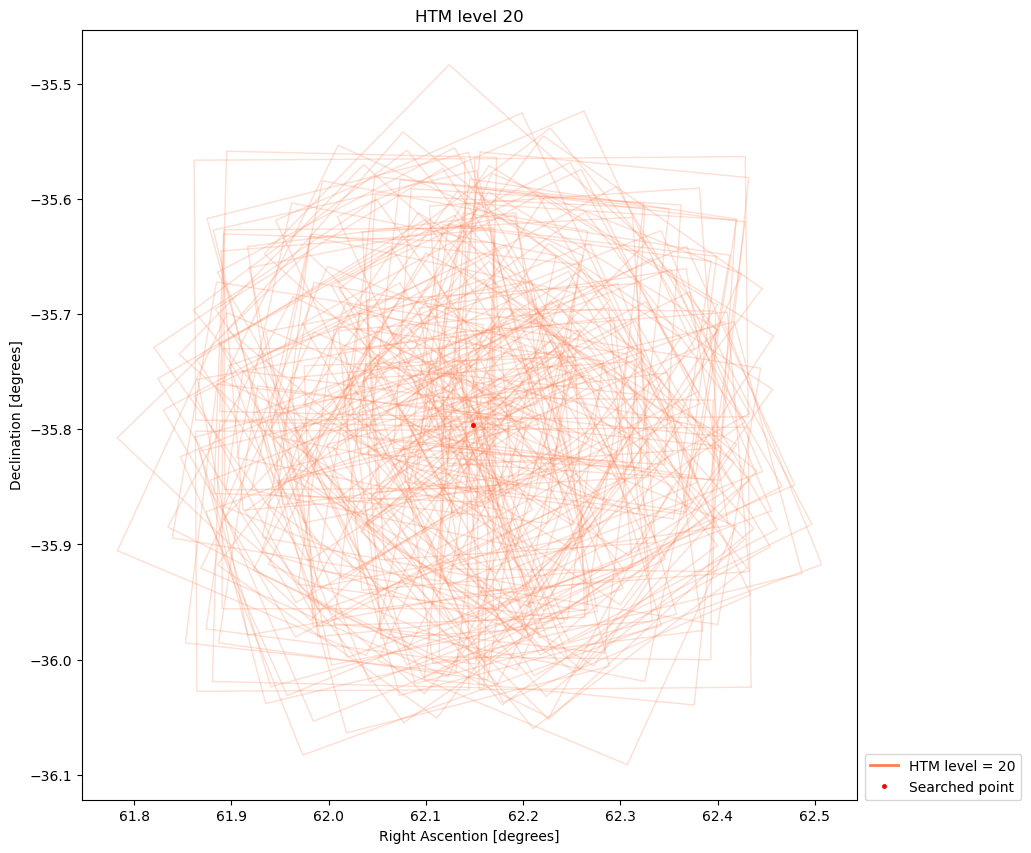

In [40]:
def plot_htm(level, ra, dec, color=None, circle=False, calexp=False, lwT=2, lwC=2, lwc=1):
    pixelization = lsst.sphgeom.HtmPixelization(level)
    htm_id = pixelization.index(lsst.sphgeom.UnitVector3d(lsst.sphgeom.LonLat.fromDegrees(ra, dec)))
    circle = pixelization.triangle(htm_id).getBoundingCircle()
    tri_ra_dec=[]
    for uni in pixelization.triangle(htm_id).getVertices():
        tri_ra_dec.append([sphgeom.LonLat.longitudeOf(uni).asDegrees(),sphgeom.LonLat.latitudeOf(uni).asDegrees()])
    poli =Polygon(tri_ra_dec)
    x, y = poli.exterior.xy
    plt.plot(x, y,  alpha=1, color=color, linewidth=lwT, label = f"HTM level = {level}")
    ret = []
    if circle:
        uni=circle.getCenter()
        ra_c, dec_c = sphgeom.LonLat.longitudeOf(uni).asDegrees(), sphgeom.LonLat.latitudeOf(uni).asDegrees()
        r = circle.getOpeningAngle().asDegrees()
        circ = plt.Circle((ra_c,dec_c), r, linewidth=lwC, linestyle="--", color=colors[lvl-1],fill=False, label="Bounding circle")
        ret.append(circ)
    if calexp:
        RA=[]; DEC=[]
        datasetRefs = butler.registry.queryDatasets("calexp", htm20=htm_id,where=f"band = '{band}'")   
        print(len(list(datasetRefs)))
        for dataRef in list(datasetRefs):
            ref_dataId = dataRef.dataId
            cal = butler.get('calexp', dataId=ref_dataId)
            ra_corners, dec_corners = get_calexp_corners(cal)
            RA.append(ra_corners); DEC.append(dec_corners)
        polygons = [Polygon(zip(ra, dec)) for ra, dec in zip(RA, DEC)]
        for polygon in polygons:
            if polygon.contains(Point(ra,dec)):
                k+=1
                x, y = polygon.exterior.xy
                ax.plot(x, y, color, alpha=0.25, linewidth=lwc)
        ret.append(datasetRefs)
        ret.append(k)
    return ret
    
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'orange', 'brown',
          'teal', 'pink', 'gray', 'gold', 'lime', 'navy', 'maroon', 'olive', 'silver', 'aqua',
          'coral', 'turquoise', 'salmon', 'orchid', 'plum']
lvl=20; band="r"
ra = 62.149
dec = -35.796
from shapely.geometry import Polygon
fig, ax = plt.subplots(figsize=(10,10))
plot_htm(lvl# Count calexp per htm level
ra = 62.149
dec = -35.796
band = "r"
# data = inj_ext_loc(band, ra, dec, model, start=0, finish=3, htm_lvl=18)
RA={}; DEC={}
# start = 0 ;finish = 139
Levels = np.arange(1,21)
N_calexps=[]
for lvl in range(1,21):
    pixelization = lsst.sphgeom.HtmPixelization(lvl)
    htm_id = pixelization.index(lsst.sphgeom.UnitVector3d(lsst.sphgeom.LonLat.fromDegrees(ra, dec)))
    circle = pixelization.triangle(htm_id).getBoundingCircle()
    scale = circle.getOpeningAngle().asDegrees()*3600.
    level = pixelization.getLevel()
    print("{:<20}".format(f'({ra}, {dec})') + f'HTM ID={htm_id} at level={level} is bounded by a circle of radius ~{scale:0.2f} arcsec.')
    datasetRefs = butler.registry.queryDatasets("calexp", htm20=htm_id,where=f"band = '{band}'")   
    n=len(list(datasetRefs))
    print("{:<20}".format("") + f"Found {n} calexps")
    N_calexps.append(n)


plt.plot(Levels, np.log10(N_calexps), ".-")
plt.xticks(Levels)
plt.xlabel("HTM level")
plt.ylabel("count of calexps $[\log]$")
plt.title("Obtanied calexps per HTM level")
plt.grid()

plt.figure()
plt.plot(Levels, N_calexps, ".-")
plt.xticks(Levels)
plt.xlabel("HTM level")
plt.ylabel("count of calexps")
plt.title("Obtanied calexps per HTM level")
plt.grid()
ax.plot(ra, dec, ".r", markersize=5, label="Searched point")
plt.title(f"HTM level {lvl}")
plt.xlabel("Right Ascention [degrees]")
plt.ylabel("Declination [degrees]")
plt.legend(loc=(1.01,0))

In [34]:
# Count calexp per htm level
ra = 62.149
dec = -35.796
band = "r"
# data = inj_ext_loc(band, ra, dec, model, start=0, finish=3, htm_lvl=18)
RA={}; DEC={}
# start = 0 ;finish = 139
Levels = np.arange(1,21)
N_calexps=[]
import time
times = []
for lvl in range(6,21):
    t0=time.time()
    pixelization = lsst.sphgeom.HtmPixelization(lvl)
    htm_id = pixelization.index(lsst.sphgeom.UnitVector3d(lsst.sphgeom.LonLat.fromDegrees(ra, dec)))
    circle = pixelization.triangle(htm_id).getBoundingCircle()
    scale = circle.getOpeningAngle().asDegrees()*3600.
    level = pixelization.getLevel()
    print("{:<20}".format(f'({ra}, {dec})') + f'HTM ID={htm_id} at level={level} is bounded by a circle of radius ~{scale:0.2f} arcsec.')
    datasetRefs = butler.registry.queryDatasets("calexp", htm20=htm_id,where=f"band = '{band}'")   
    n=len(list(datasetRefs))
    print("{:<20}".format("") + f"Found {n} calexps")
    N_calexps.append(n)
    t1=time.time()
    times.append(t1-t0)

                    Found 14312 calexps
                    Found 5494 calexps
                    Found 1811 calexps
                    Found 777 calexps
                    Found 284 calexps
                    Found 200 calexps
                    Found 173 calexps
                    Found 154 calexps
                    Found 149 calexps
                    Found 140 calexps
                    Found 140 calexps
                    Found 140 calexps
                    Found 140 calexps
                    Found 139 calexps
                    Found 139 calexps


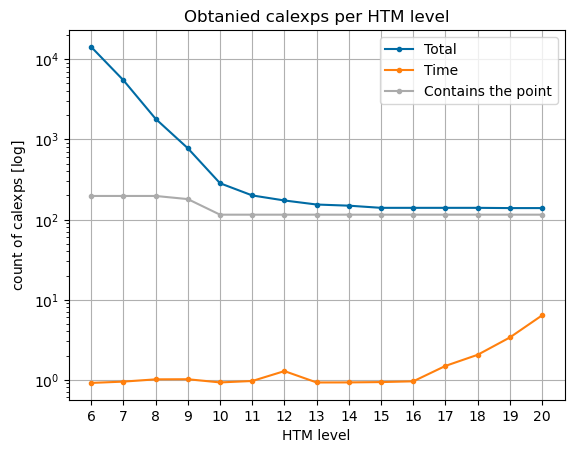

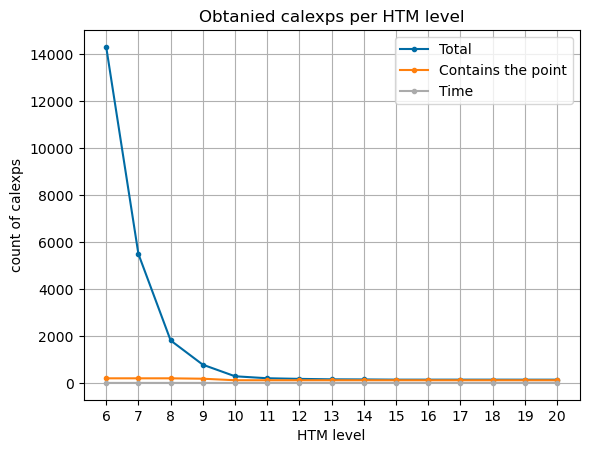

In [37]:
net_calexps=np.loadtxt('outputs/net_calexp.txt', dtype=int)
x=[20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6]
plt.plot(x, N_calexps[::-1], ".-", label="Total")
plt.plot(x, times, ".-", label="Time")
plt.plot(x, net_calexps, ".-", label="Contains the point")
plt.xticks(x)
plt.yscale('log')
plt.xlabel("HTM level")
plt.ylabel("count of calexps $[\log]$")
plt.title("Obtanied calexps per HTM level")
plt.grid()
plt.legend()
plt.savefig("Count_calexp_log.png")

plt.figure()
plt.plot(x, N_calexps[::-1], ".-",label="Total")
plt.plot(x, net_calexps, ".-", label="Contains the point")
plt.plot(x, times, ".-", label="Time")
plt.xticks(x)
plt.xlabel("HTM level")
plt.ylabel("count of calexps")
plt.title("Obtanied calexps per HTM level")
plt.grid()
plt.legend()
plt.savefig("Count_calexp.png")


In [12]:
net_calexps=np.loadtxt('outputs/net_calexp.txt', dtype=int)
net_calexps

array([115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 180, 197,
       197, 197])

In [13]:
import numpy as np
from astropy import units as u
from lsst.afw.image import ExposureF
ra = 62.149
dec = -35.796
band = "r"

ra_min, ra_max = 0, 180  # RA va de 0 a 360 grados
dec_min, dec_max = -90, 0  # DEC va de -90 a 90 grados
ra_step = 2.0 
dec_step = 2.0 
ra_values = np.arange(ra_min, ra_max, ra_step)
dec_values = np.arange(dec_min, dec_max, dec_step)
ra_grid, dec_grid = np.meshgrid(ra_values, dec_values)
ra_flat = ra_grid.flatten()
dec_flat = dec_grid.flatten()
N_calexps = np.zeros_like(ra_grid, dtype=int)
pixelization = sphgeom.HtmPixelization(20)


try:
    for ra, dec in zip(ra_flat, dec_flat):
        ra_idx = np.where(ra_values == ra)[0][0]
        dec_idx = np.where(dec_values == dec)[0][0]
        htm_id = pixelization.index(sphgeom.UnitVector3d(sphgeom.LonLat.fromDegrees(ra, dec)))
        datasetRefs = butler.registry.queryDatasets("calexp", htm20=htm_id,where=f"band = '{band}'")   
        N_calexps[dec_idx, ra_idx] = len(list(datasetRefs))
except ValueError as e:
    print(f'Error: {e}')


In [70]:
non_zero_coords = np.argwhere(N_calexps != 0)
dec_min_idx, ra_min_idx = non_zero_coords.min(axis=0)
dec_max_idx, ra_max_idx = non_zero_coords.max(axis=0)

print(f'Simulation index limits:')
print(f'RA min index: {ra_min_idx}')
print(f'RA max index: {ra_max_idx}')
print(f'DEC min index: {dec_min_idx}')
print(f'DEC max index: {dec_max_idx}')

ra_min = ra_values[ra_min_idx]
ra_max = ra_values[ra_max_idx]
dec_min = dec_values[dec_min_idx]
dec_max = dec_values[dec_max_idx]

print(f'Simulation (ra,dec) limits')
print(f'RA min: {ra_min} degrees')
print(f'RA max: {ra_max} degrees')
print(f'DEC min: {dec_min} degrees')
print(f'DEC max: {dec_max} degrees')

Simulation index limits:
RA min index: 24
RA max index: 38
DEC min index: 23
DEC max index: 31
Simulation (ra,dec) limits
RA min: 48.0 degrees
RA max: 76.0 degrees
DEC min: -44.0 degrees
DEC max: -28.0 degrees


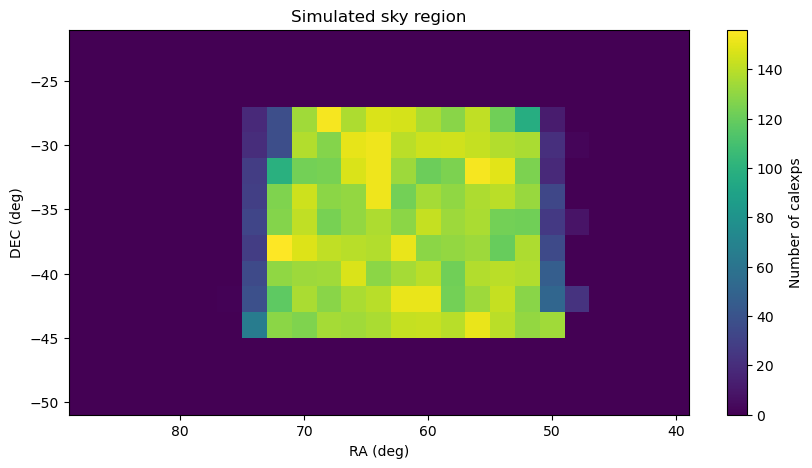

In [69]:
plt.figure(figsize=(10, 5))
r_m, r_M = 20,45
d_m, d_M = 20,35
plt.pcolormesh(ra_values[r_m:r_M], dec_values[d_m:d_M], N_calexps[d_m:d_M,r_m:r_M], shading='auto', cmap='viridis')
plt.colorbar(label='Number of calexps')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.title('Simulated sky region')
plt.gca().invert_xaxis()  # Invertir el eje X para mostrar RA correctamente
plt.show()

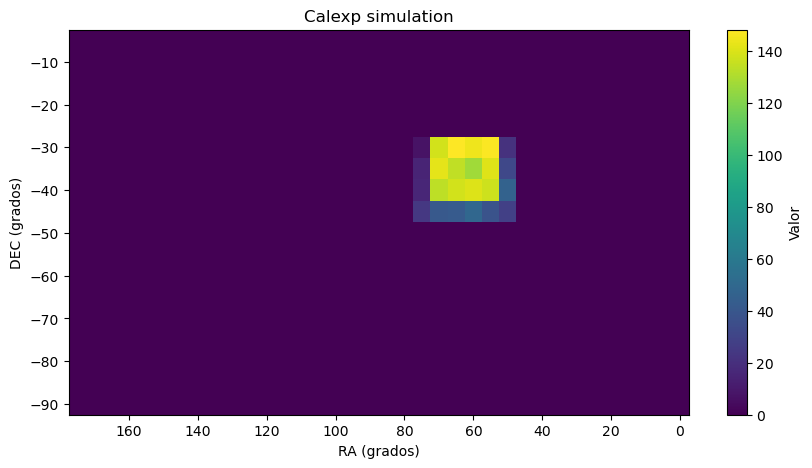

In [12]:
plt.figure(figsize=(10, 5))
plt.pcolormesh(ra_values, dec_values, valores, shading='auto', cmap='viridis')
plt.colorbar(label='Valor')
plt.xlabel('RA (grados)')
plt.ylabel('DEC (grados)')
plt.title('Calexp simulation')
plt.gca().invert_xaxis()  # Invertir el eje X para mostrar RA correctamente
plt.show()

In [22]:
net_calexps

array([115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 180, 197,
       197, 197])

In [25]:
def create_zip(zip_name, files):
    with zipfile.ZipFile(zip_name, 'w') as zipf:
        for file in files:
            zipf.write(file, os.path.basename(file))

# Example usage
files_to_zip = [name for name in os.listdir() if name.startswith("true_cal") ]#or name.startswith("uLens")]  # Replace with your actual file names
create_zip("true_cal.zip", files_to_zip)

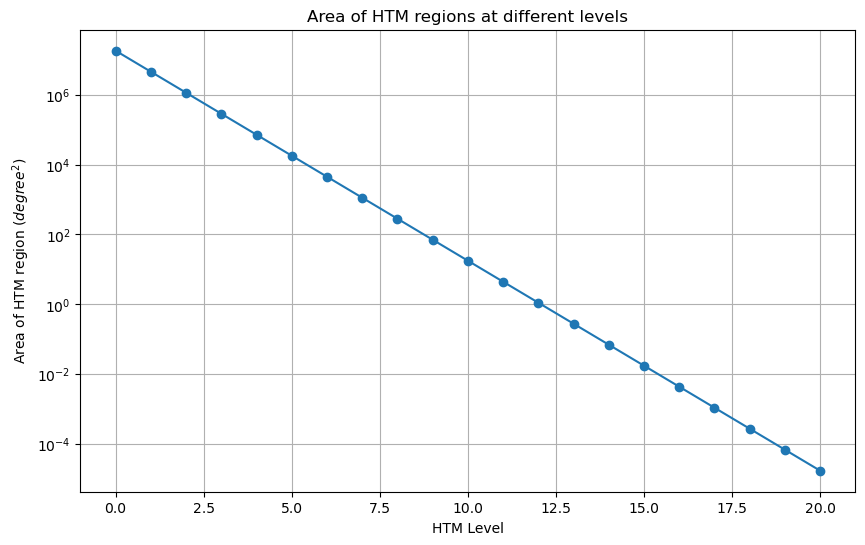

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def htm_area(level):
    return np.pi / (2 ** (2 * level + 1))

levels = np.arange(0, 21)
areas = [htm_area(level) * ((180 * 3600 / np.pi)**2)/(60**2) for level in levels]


plt.figure(figsize=(10, 6))
plt.plot(levels, areas, marker='o')
plt.yscale('log')  
plt.xlabel('HTM Level')
# plt.xlim(0,20)
plt.ylabel('Area of HTM region ($degree^2$)')
plt.title('Area of HTM regions at different levels')
plt.grid(True)
plt.show()

In [10]:
areas

[66829797224.05923,
 16707449306.014807,
 4176862326.5037017,
 1044215581.6259254,
 261053895.40648136,
 65263473.85162034,
 16315868.462905085,
 4078967.115726271,
 1019741.7789315678,
 254935.44473289195,
 63733.86118322299,
 15933.465295805747,
 3983.3663239514367,
 995.8415809878592,
 248.9603952469648,
 62.2400988117412,
 15.5600247029353,
 3.890006175733825,
 0.9725015439334562,
 0.24312538598336406,
 0.060781346495841014]

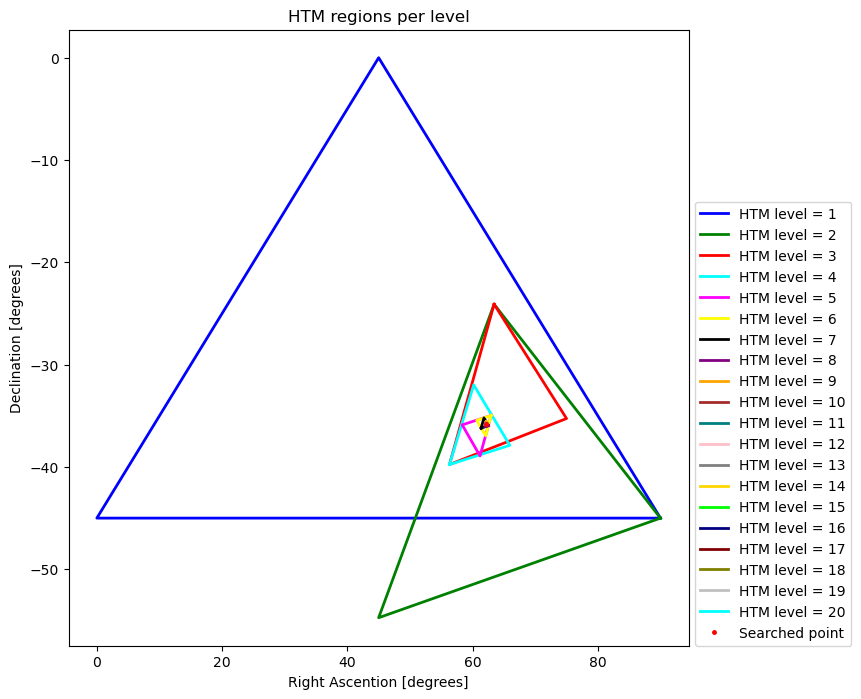

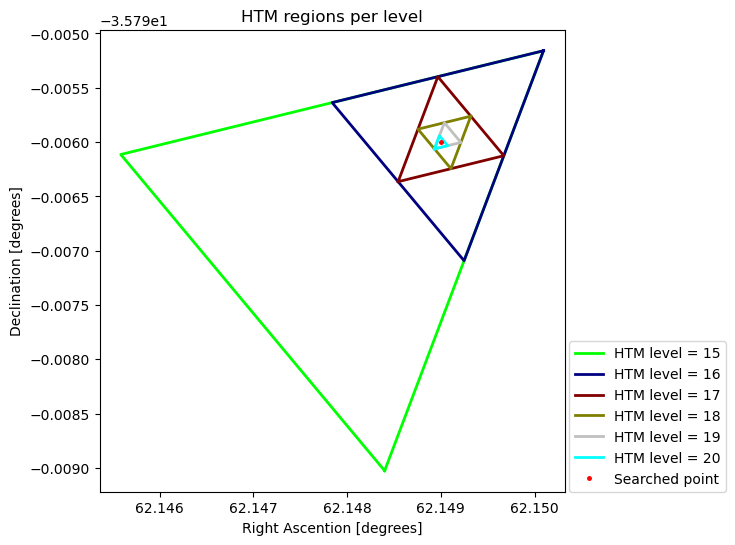

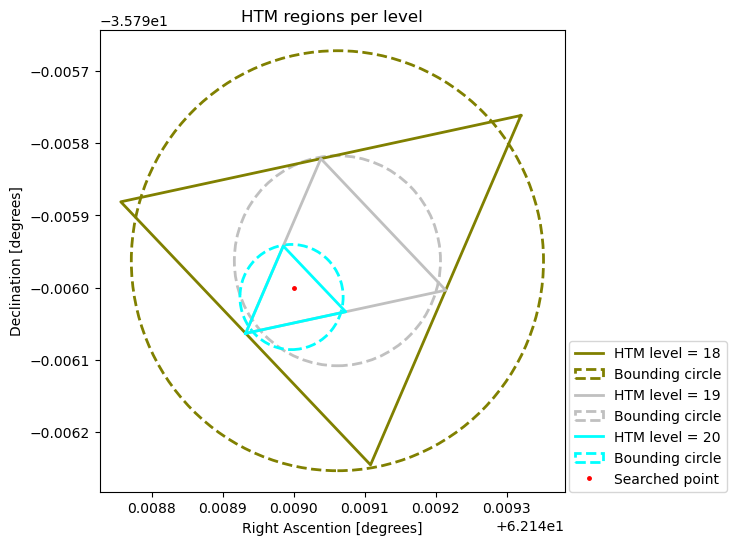

In [8]:
import itertools
from shapely.geometry import Polygon
from shapely.ops import unary_union
def plot_htm(level, ra, dec, color=None, circle=False, calexp=False, lwT=2, lwC=2, lwc=1):
    pixelization = lsst.sphgeom.HtmPixelization(level)
    htm_id = pixelization.index(lsst.sphgeom.UnitVector3d(lsst.sphgeom.LonLat.fromDegrees(ra, dec)))
    circle = pixelization.triangle(htm_id).getBoundingCircle()
    tri_ra_dec=[]
    for uni in pixelization.triangle(htm_id).getVertices():
        tri_ra_dec.append([sphgeom.LonLat.longitudeOf(uni).asDegrees(),sphgeom.LonLat.latitudeOf(uni).asDegrees()])
    poli =Polygon(tri_ra_dec)
    x, y = poli.exterior.xy
    plt.plot(x, y,  alpha=1, color=color, linewidth=lwT, label = f"HTM level = {level}")
    ret = []
    if circle:
        uni=circle.getCenter()
        ra_c, dec_c = sphgeom.LonLat.longitudeOf(uni).asDegrees(), sphgeom.LonLat.latitudeOf(uni).asDegrees()
        r = circle.getOpeningAngle().asDegrees()
        circ = plt.Circle((ra_c,dec_c), r, linewidth=lwC, linestyle="--", color=colors[lvl-1],fill=False, label="Bounding circle")
        ret.append(circ)
    if calexp:
        RA=[]; DEC=[]
        datasetRefs = butler.registry.queryDatasets("calexp", htm20=htm_id,where=f"band = '{band}'")   
        for dataRef in list(datasetRefs):
            ref_dataId = dataRef.dataId
            cal = butler.get('calexp', dataId=ref_dataId)
            ra_corners, dec_corners = get_calexp_corners(cal)
            RA.append(ra_corners); DEC.append(dec_corners)
        polygons = [Polygon(zip(ra, dec)) for ra, dec in zip(RA, DEC)]
        for polygon in polygons:
            x, y = polygon.exterior.xy
            ax.plot(x, y, color, alpha=0.25, linewidth=lwc)
        ret.append(datasetRefs)
    return ret

ra = 62.149
dec = -35.796

colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'orange', 'brown',
          'teal', 'pink', 'gray', 'gold', 'lime', 'navy', 'maroon', 'olive', 'silver', 'aqua',
          'coral', 'turquoise', 'salmon', 'orchid', 'plum']
plt.figure(figsize=(8,8))
for lvl in range(1,21):
    plot_htm(lvl, ra, dec, colors[lvl-1])

plt.plot(ra, dec, ".r", markersize=5, label="Searched point")
plt.title("HTM regions per level")
plt.xlabel("Right Ascention [degrees]")
plt.ylabel("Declination [degrees]")
plt.legend(loc=(1.01,0))
plt.savefig("HTM_1to20.png")

plt.figure(figsize=(6,6))
for lvl in range(15,21):
    plot_htm(lvl, ra, dec, colors[lvl-1])

plt.plot(ra, dec, ".r", markersize=5, label="Searched point")
plt.title("HTM regions per level")
plt.xlabel("Right Ascention [degrees]")
plt.ylabel("Declination [degrees]")
plt.legend(loc=(1.01,0))
plt.savefig("HTM_15to20.png")

fig, ax = plt.subplots(figsize=(6,6))
for lvl in range(18,21):
    circ = plot_htm(lvl, ra, dec, colors[lvl-1], circle=True)[0]
    ax.add_patch(circ)
ax.plot(ra, dec, ".r", markersize=5, label="Searched point")
plt.title("HTM regions per level")
plt.xlabel("Right Ascention [degrees]")
plt.ylabel("Declination [degrees]")
plt.legend(loc=(1.01,0))
plt.savefig("HTM_BoundCircles_18to20.png")


# fig, ax = plt.subplots() #subplot_kw={'projection': 'mollweide'})
# circ = plt.Circle((ra_c,dec_c), r, color="red")
# ax.add_patch(circ)

In [14]:
import lsst.sphgeom as sphgeom

# Crear una instancia de HtmPixelization con nivel de subdivisión 5
pixelization = sphgeom.HtmPixelization(5)

# Definir un índice HTM de ejemplo
index = 9645646590460

# Obtener el nivel de un índice
level = sphgeom.HtmPixelization.level(index)
print(f'El nivel de índice {index} es {level}.')

# Obtener el triángulo correspondiente a un índice
triangle = sphgeom.HtmPixelization.triangle(index)
print(f'El triángulo correspondiente al índice {index} es {triangle}.')

# Representar el índice como una cadena
index_str = sphgeom.HtmPixelization.asString(index)
print(f'La representación en cadena del índice {index} es {index_str}.')

# Crear un vector unitario de ejemplo
vector = sphgeom.UnitVector3d(x=0.5, y=0.5, z=0.7071)

# Obtener el índice para un vector unitario
index_for_vector = pixelization.index(vector)
print(f'El índice HTM para el vector {vector} es {index_for_vector}.')



El nivel de índice 9645646590460 es 20.
El triángulo correspondiente al índice 9645646590460 es ConvexPolygon([UnitVector3d(0.37892742399334817, 0.7171497225617168, -0.5849019428719809), UnitVector3d(0.3789258018576642, 0.7171509242603574, -0.5849015203596596), UnitVector3d(0.3789273370120379, 0.7171511633851502, -0.5849002326211634)]).
La representación en cadena del índice 9645646590460 es S030113031111223013330.
El índice HTM para el vector [0.5000023975172442, 0.5000023975172442, 0.7071033905688867] es 16351.


In [22]:
help(triangle.getVertices()[0])
triangle.getVertices()[0][0]

Help on UnitVector3d in module lsst.sphgeom._sphgeom object:

class UnitVector3d(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      UnitVector3d
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __add__(...)
 |      __add__(self: lsst.sphgeom._sphgeom.UnitVector3d, arg0: lsst.sphgeom._sphgeom.Vector3d) -> lsst.sphgeom._sphgeom.Vector3d
 |  
 |  __eq__(...)
 |      __eq__(self: lsst.sphgeom._sphgeom.UnitVector3d, arg0: lsst.sphgeom._sphgeom.Vector3d) -> bool
 |  
 |  __getitem__(...)
 |      __getitem__(self: lsst.sphgeom._sphgeom.UnitVector3d, arg0: int) -> float
 |  
 |  __getstate__(...)
 |      __getstate__(self: lsst.sphgeom._sphgeom.UnitVector3d) -> tuple
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: lsst.sphgeom._sphgeom.UnitVector3d) -> None
 |      
 |      2. __init__(self: lsst.sphgeom._sphgeom.UnitVector3d, unitVector: lsst.s

0.37892742399334817

In [71]:
import pandas as pd
df = pd.read_csv("uLens-m_t20.csv")

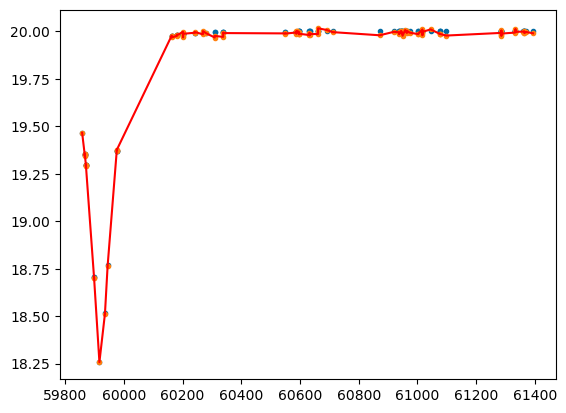

In [73]:
mjds = df["mjds"]
mags_measured= df["mags_measured"]
mags_errors=df["mags_errors"]
mags_injected=df["mags_injected"]
plt.errorbar(mjds, mags_measured, yerr=mags_errors, markersize=10, color= "red")
plt.plot(mjds, mags_injected, ".")
plt.plot(mjds, mags_measured, ".")

In [40]:
def SkyToPix(ra,dec, img):
    xy = img.getWcs().skyToPixel(geom.SpherePoint(ra*geom.degrees, dec*geom.degrees))
    x = int(np.round(xy.x))
    y = int(np.round(xy.y))
    return x , y

def PixToSky(x, y, img):
    sphere_point = img.getWcs().pixelToSky(geom.Point2D(x, y))
    ra = sphere_point.getRa().asDegrees()
    dec = sphere_point.getDec().asDegrees()
    return ra, dec
import lsst.afw.image as afwImage
def cutout(img, ra, dec , size):
    '''Create a cutout of an input image array

    Parameters
    ----------
    im: `Image`
        Input image (extracted from an ExposureF) to cut down
    xcen, ycen: `int`
        Integer XY coordinates to center the cutout on
    size: `int`
        Width in pixels of the resulting image
    '''
    x,y=SkyToPix(ra, dec, img)
    try:
        return img[x-size/2:x+size/2, y-size/2:y+size/2]
    except Exception as e:
        print(f"Couldn't cut image. Expeption: {e}")
        return img

import matplotlib.patches as patches

# def cutout(img, ra, dec, size):
#     '''Create a cutout of an input image array

#     Parameters
#     ----------
#     img: `ExposureF`
#         Input image to cut down
#     ra, dec: `float`
#         RA and Dec coordinates to center the cutout on
#     size: `int`
#         Width in pixels of the resulting image
#     '''
#     x, y = SkyToPix(ra, dec, img)

#     # Definir el centro y tamaño del recorte usando Box2I
#     center = geom.Point2I(int(x), int(y))
#     bbox = geom.Box2I(center, geom.Extent2I(size, size))

#     try:
#         # Crear el recorte con el origen PARENT
#         sub_img = afwImage.ExposureF(img, bbox, afwImage.PARENT)
#         return sub_img
#     except Exception as e:
#         print(f"Couldn't cut image. Exception: {e}")
#         return img



def calexp_plot(img, title, fig=None, ax=None, warp=None, cut=None, point_out=False, cutsize=None):
    '''warp: calexp_ref'''
    l=1
    if warp!=None:
        img = warp_img(warp, img, warp.getWcs())
    if type(cut)!=type(None):
        ra, dec = cut[:,0], cut[:,1]
        size = 401
        if cutsize!=None:
            size = cutsize
            l*=cutsize/size
        img = cutout(img, ra[0], dec[0], size)
    if fig==None:
        fig, ax = plt.subplots(1)   
    display0 = afwDisplay.Display(frame=fig)
    # display0.scale('linear', 'zscale')
    display0.scale('linear', min=-100, max=250)
    display0.mtv(img.image)
    plt.title(title, fontsize=8)
    if point_out:
        for h, (rai, deci) in enumerate(zip(ra,dec)):
            x,y=SkyToPix(rai, deci, img)
            rect = patches.Rectangle((x - size/16, y - size/16), size/8, size/8, edgecolor="r", linewidth=1, facecolor='none')
            ax.add_patch(rect)
    ax.axis('off')


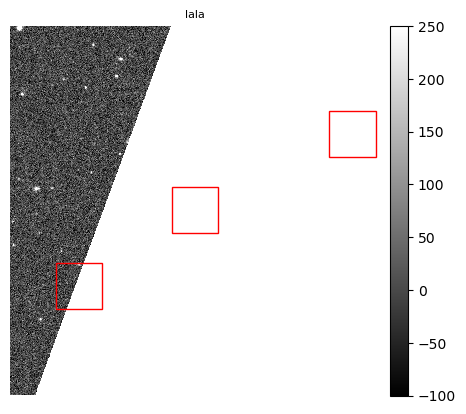

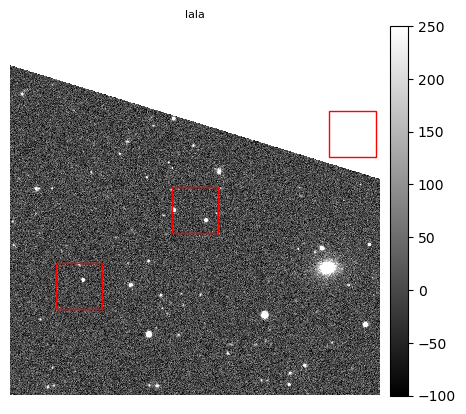

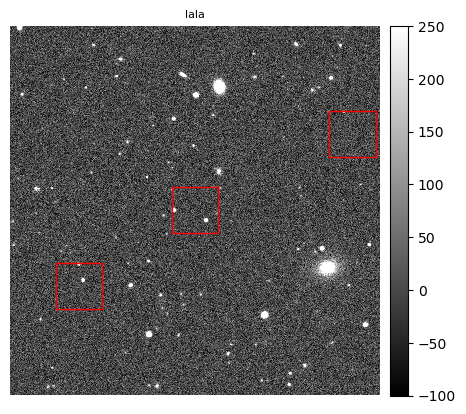

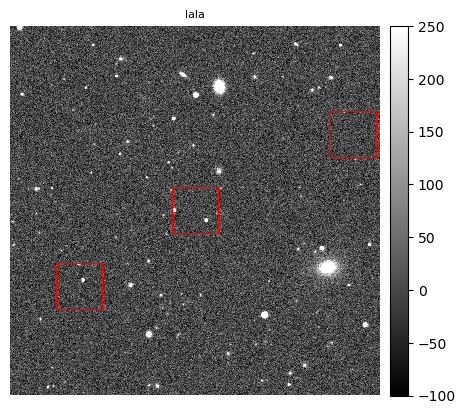

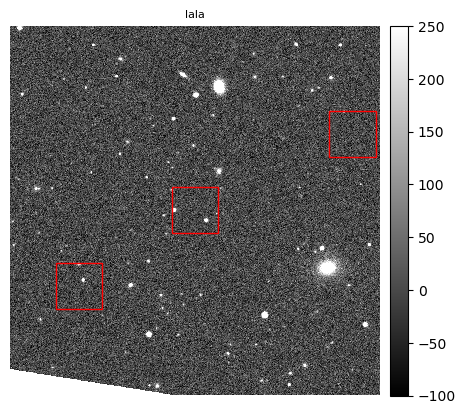

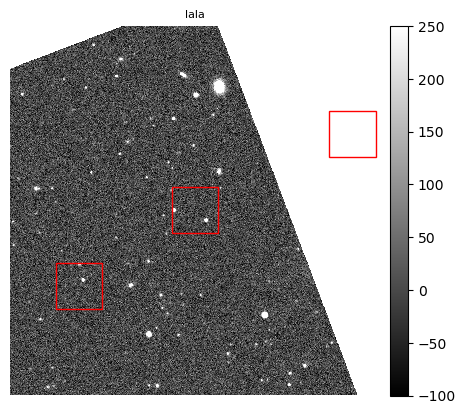

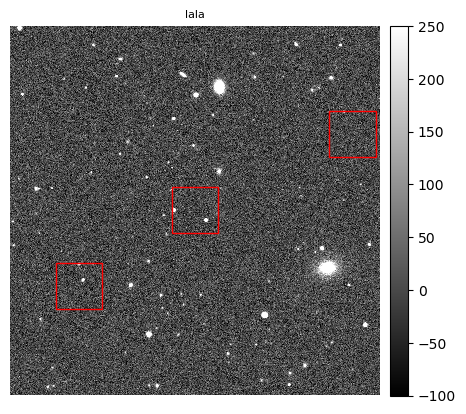

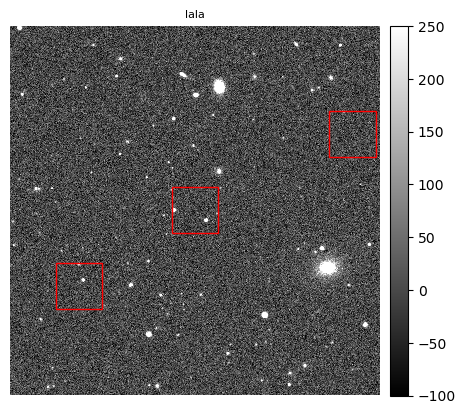

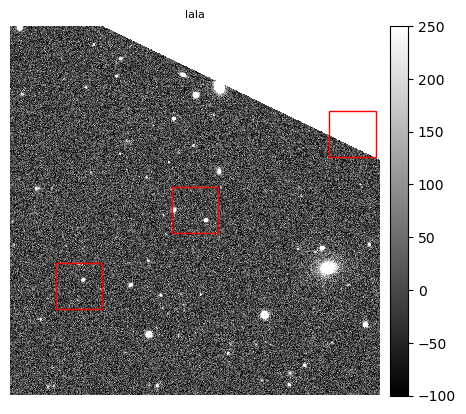

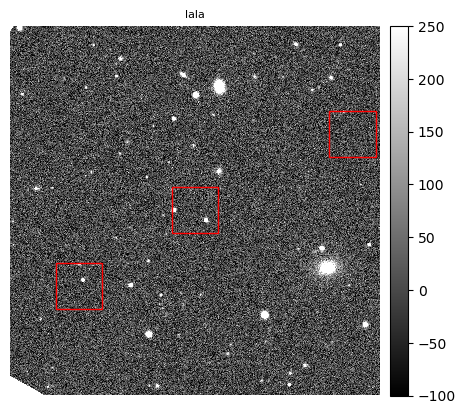

In [41]:
from astropy.wcs import WCS
# ra = 62.149
# dec = -35.796
# exp_midpoints, visits, detectors, datasetRefs_list = calexp_from_loc(ra, dec)
# locs = np.array([(ra, dec),(62.13, -35.81),(62.17, -35.776)])
# n_points = len(locs)
calexp_ref, psf_ref, phot_calib_ref, wcs_ref, xy_ref= get_calexp_data(datasetRefs_list[0])
for i in range(50,60):
    calexp= butler.get('calexp', dataId= datasetRefs_list[i].dataId)
    calexp_plot(calexp,"lala", warp=calexp_ref ,cut=locs, point_out=True, cutsize=1001) 

In [32]:
dir(calexp)

['Factory',
 '__add__',
 '__class__',
 '__deepcopy__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '_get',
 '_set',
 'apCorrMap',
 'clone',
 'containsSkyCoords',
 'convertD',
 'convertF',
 'convex_polygon',
 'detector',
 'dtype',
 'filter',
 'getBBox',
 'getConvexPolygon',
 'getCutout',
 'getDetector',
 'getDimensions',
 'getFilter',
 'getHeight',
 'getImage',
 'getInfo',
 'getMask',
 'getMaskedImage',
 'getMetadata',
 'getPhotoCalib',
 'getPsf',
 'getVariance',
 'getWcs',
 'getWidth',
 'getX0',
 'getXY0',
 'getY0',
 'hasPsf',
 'hasWcs',
 'height',
 'image',
 'info